# 1- Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
import numpy as np

# 2- Data Cleaning et preprocessing

In [ ]:
def fix_gotoes_header(filepath):
    """
    Corrige les CSV Garmin exportés avec un header décalé (colonne 'GOTOES_CSV').
    → Décale tous les noms de colonnes d’un cran vers la gauche.
    """
    df = pd.read_csv(filepath, header=0)
    if df.columns[0] == 'GOTOES_CSV':
        print(f"⚙️ Correction du header 'GOTOES_CSV' dans {filepath.split('\\')[-1]}")
        new_cols = df.columns[1:].tolist() + ['extra_col']
        df.columns = new_cols
    return df


In [ ]:
marathon1 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\marathon_1.csv")
marathon2 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\marathon_2.csv")
semi1 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\semi_1.csv")
semi2 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\semi_2.csv")
semi3 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\semi_3.csv")
dix1 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\10k_1.csv")
dix2 = fix_gotoes_header(r"C:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\10k_2.csv")
print("✅ Nouvelles colonnes :", marathon1.columns[:10].tolist())
print("✅ Nouvelles colonnes :", marathon2.columns[:10].tolist())
print("✅ Nouvelles colonnes :", semi1.columns[:10].tolist())
print("✅ Nouvelles colonnes :", semi2.columns[:10].tolist())
print("✅ Nouvelles colonnes :", semi3.columns[:10].tolist())
print("✅ Nouvelles colonnes :", dix1.columns[:10].tolist())
print("✅ Nouvelles colonnes :", dix2.columns[:10].tolist())

⚙️ Correction du header 'GOTOES_CSV' dans marathon_1.csv
⚙️ Correction du header 'GOTOES_CSV' dans marathon_2.csv
⚙️ Correction du header 'GOTOES_CSV' dans semi_1.csv
⚙️ Correction du header 'GOTOES_CSV' dans semi_2.csv
⚙️ Correction du header 'GOTOES_CSV' dans semi_3.csv
⚙️ Correction du header 'GOTOES_CSV' dans semi_1.csv
⚙️ Correction du header 'GOTOES_CSV' dans semi_2.csv
⚙️ Correction du header 'GOTOES_CSV' dans semi_3.csv
⚙️ Correction du header 'GOTOES_CSV' dans 10k_1.csv
⚙️ Correction du header 'GOTOES_CSV' dans 10k_2.csv
✅ Nouvelles colonnes : ['timestamp', 'position_lat', 'position_long', 'altitude', 'heart_rate', 'cadence', 'distance', 'speed', 'power', 'compressed_speed_distance']
⚙️ Correction du header 'GOTOES_CSV' dans 10k_1.csv
⚙️ Correction du header 'GOTOES_CSV' dans 10k_2.csv
✅ Nouvelles colonnes : ['timestamp', 'position_lat', 'position_long', 'altitude', 'heart_rate', 'cadence', 'distance', 'speed', 'power', 'compressed_speed_distance']


In [ ]:
courses = {"Marathon 1": marathon1,
    "Marathon 2": marathon2,
    "Semi 1": semi1,
    "Semi 2": semi2,
    "Semi 3": semi3,
    "10 km 1": dix1,
    "10 km 2": dix2}

In [ ]:
#Colonnes qui nous intéressent 
cols = ['distance', 'timestamp', 'stance_time', 
        'vertical_oscillation', 'step_length', 
        'enhanced_speed', 'heart_rate', 'enhanced_altitude']


In [ ]:
def prepare_course(df, course_name):
    """
    Nettoie et prépare les données Garmin avec les bonnes unités :
      - Supprime les lignes invalides
      - Convertit les colonnes en unités cohérentes
      - Filtre les valeurs aberrantes
    """
    cols = ['distance', 'timestamp', 'stance_time', 'vertical_oscillation', 'step_length',
            'enhanced_speed', 'heart_rate', 'enhanced_altitude']

    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"❌ Colonnes manquantes dans {course_name}: {missing}")

    df = df[cols].copy()
    df = df.dropna()

    # Nettoyage du dataset en enlevant les valeurs aberrantes souvent liées au temps avant le départ
    df = df[df['stance_time'] <= 1500]

    # Modification des unités pour correspondre à l'application Garmin d'Anto
    # vertical_oscillation : divisé par 10 → passe en centimètres
    df['vertical_oscillation'] = df['vertical_oscillation'] / 10.0
    # step_length : divisé par 1000 → passe en mètres
    df['step_length'] = df['step_length'] / 1000.0
    df = df[df['enhanced_speed'] > 0]
    print(f"✅ {course_name} : {len(df)} lignes valides après nettoyage")
    return df


marathon1_clean = prepare_course(marathon1, "Marathon 1")
marathon2_clean = prepare_course(marathon2, "Marathon 2")
semi1_clean = prepare_course(semi1, "Semi 1")
semi2_clean = prepare_course(semi2, "Semi 2")
semi3_clean = prepare_course(semi3, "Semi 3")
dix1_clean = prepare_course(dix1, "Dix 1")
dix2_clean = prepare_course(dix2, "dix 2")


✅ Marathon 1 : 12131 lignes valides après nettoyage


# 3- Description biomécanique

In [ ]:
#Données de base des données biomécaniques
def describe_biomechanics(df, course_name):
    stats = df[['enhanced_speed', 'heart_rate', 'stance_time',
                'vertical_oscillation', 'step_length']].describe().T.round(3)
    print(f"\n📊 Statistiques descriptives — {course_name}")
    print(stats)
    return stats

describe_biomechanics(marathon1_clean, "Marathon 1")



📊 Statistiques descriptives — Marathon 1
                        count     mean    std      min      25%      50%  \
enhanced_speed        12131.0   12.521  1.139    5.778   11.923   12.528   
heart_rate            12131.0  142.145  5.016   69.000  140.000  143.000   
stance_time           12131.0  240.030  9.931  202.000  235.000  239.000   
vertical_oscillation  12131.0    9.506  0.400    4.100    9.240    9.500   
step_length           12131.0    1.188  0.102    0.418    1.132    1.188   

                          75%      max  
enhanced_speed         13.201   17.600  
heart_rate            145.000  150.000  
stance_time           245.000  309.000  
vertical_oscillation    9.770   11.850  
step_length             1.248    1.746  


,count,mean,std,min,25%,50%,75%,max
enhanced_speed,12131.0,12.521,1.139,5.778,11.923,12.528,13.201,17.600
heart_rate,12131.0,142.145,5.016,69.000,140.000,143.000,145.000,150.000
stance_time,12131.0,240.030,9.931,202.000,235.000,239.000,245.000,309.000
vertical_oscillation,12131.0,9.506,0.400,4.100,9.240,9.500,9.770,11.850
step_length,12131.0,1.188,0.102,0.418,1.132,1.188,1.248,1.746


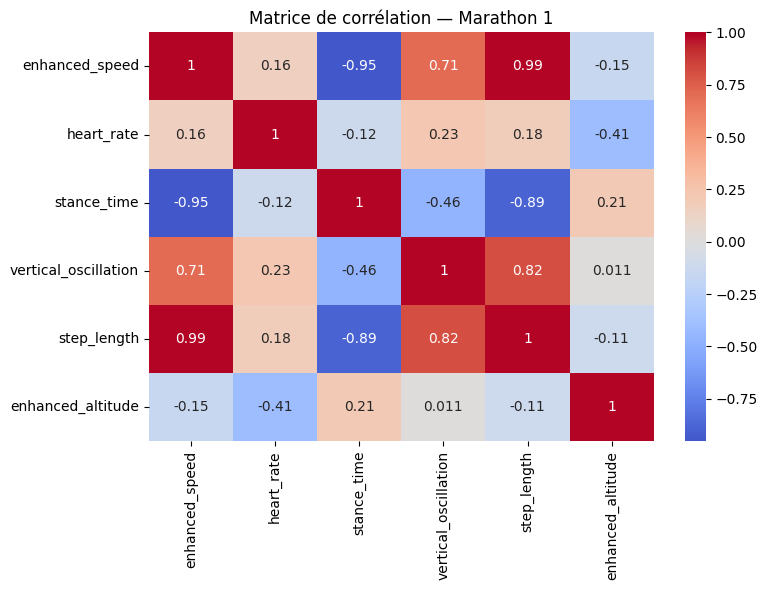


✅ Corrélations principales (Marathon 1):
  ➕ step_length ↔ speed : 0.985
  ➖ stance_time ↔ speed : -0.953
  ➖ altitude ↔ speed    : -0.148
  ➕ heart_rate ↔ altitude : -0.409


In [ ]:
#Heatmap de corrélation entre les variables biomécaniques
def plot_correlations(df, course_name):
    corr = df[['enhanced_speed', 'heart_rate', 'stance_time',
               'vertical_oscillation', 'step_length', 
               'enhanced_altitude']].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title(f"Matrice de corrélation — {course_name}")
    plt.tight_layout()
    plt.show()    

plot_correlations(marathon1_clean, "Marathon 1")
plot_correlations(marathon2_clean, "Marathon 1")
plot_correlations(marathon1_clean, "Marathon 1")
plot_correlations(marathon1_clean, "Marathon 1")
plot_correlations(marathon1_clean, "Marathon 1")
plot_correlations(marathon1_clean, "Marathon 1")
plot_correlations(marathon1_clean, "Marathon 1")
plot_correlations(marathon1_clean, "Marathon 1")



# 4 - Analyse approfondie de la biomécanique de course


Dans cette section, notre objectif est de réaliser plusieurs analyses avancées sur nos variables biomécaniques :
1. Leur évolution au fil du temps
2. Définition et Détection des zones d'effort et récupération
3. Analyse des cycles de foulée pour prévoir des optimisations
4. Tentatives de prédiction pour les performances futures

In [ ]:
def prepare_time_series(df):
    """
    Prépare les séries temporelles pour l'analyse avec un index temporel
    """
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    
    #Passage en pace et fréquence de foulée
    df['pace'] = 60 / df['enhanced_speed']  
    df['stride_frequency'] = (df['enhanced_speed'] * 1000/3600) / df['step_length']  #Nombre de pas par seconde
    return df

# Préparation des données pour toutes les courses
time_series = {}
for name, course in courses.items():
    clean_course = prepare_course(course, name)
    time_series[name] = prepare_time_series(clean_course)

✅ Marathon 1 : 12131 lignes valides après nettoyage
✅ Marathon 2 : 11408 lignes valides après nettoyage
✅ Semi 1 : 5635 lignes valides après nettoyage
✅ Semi 2 : 5636 lignes valides après nettoyage
✅ Semi 3 : 5187 lignes valides après nettoyage
✅ 10 km 1 : 3022 lignes valides après nettoyage
✅ 10 km 2 : 2732 lignes valides après nettoyage
✅ Séries temporelles préparées pour toutes les courses


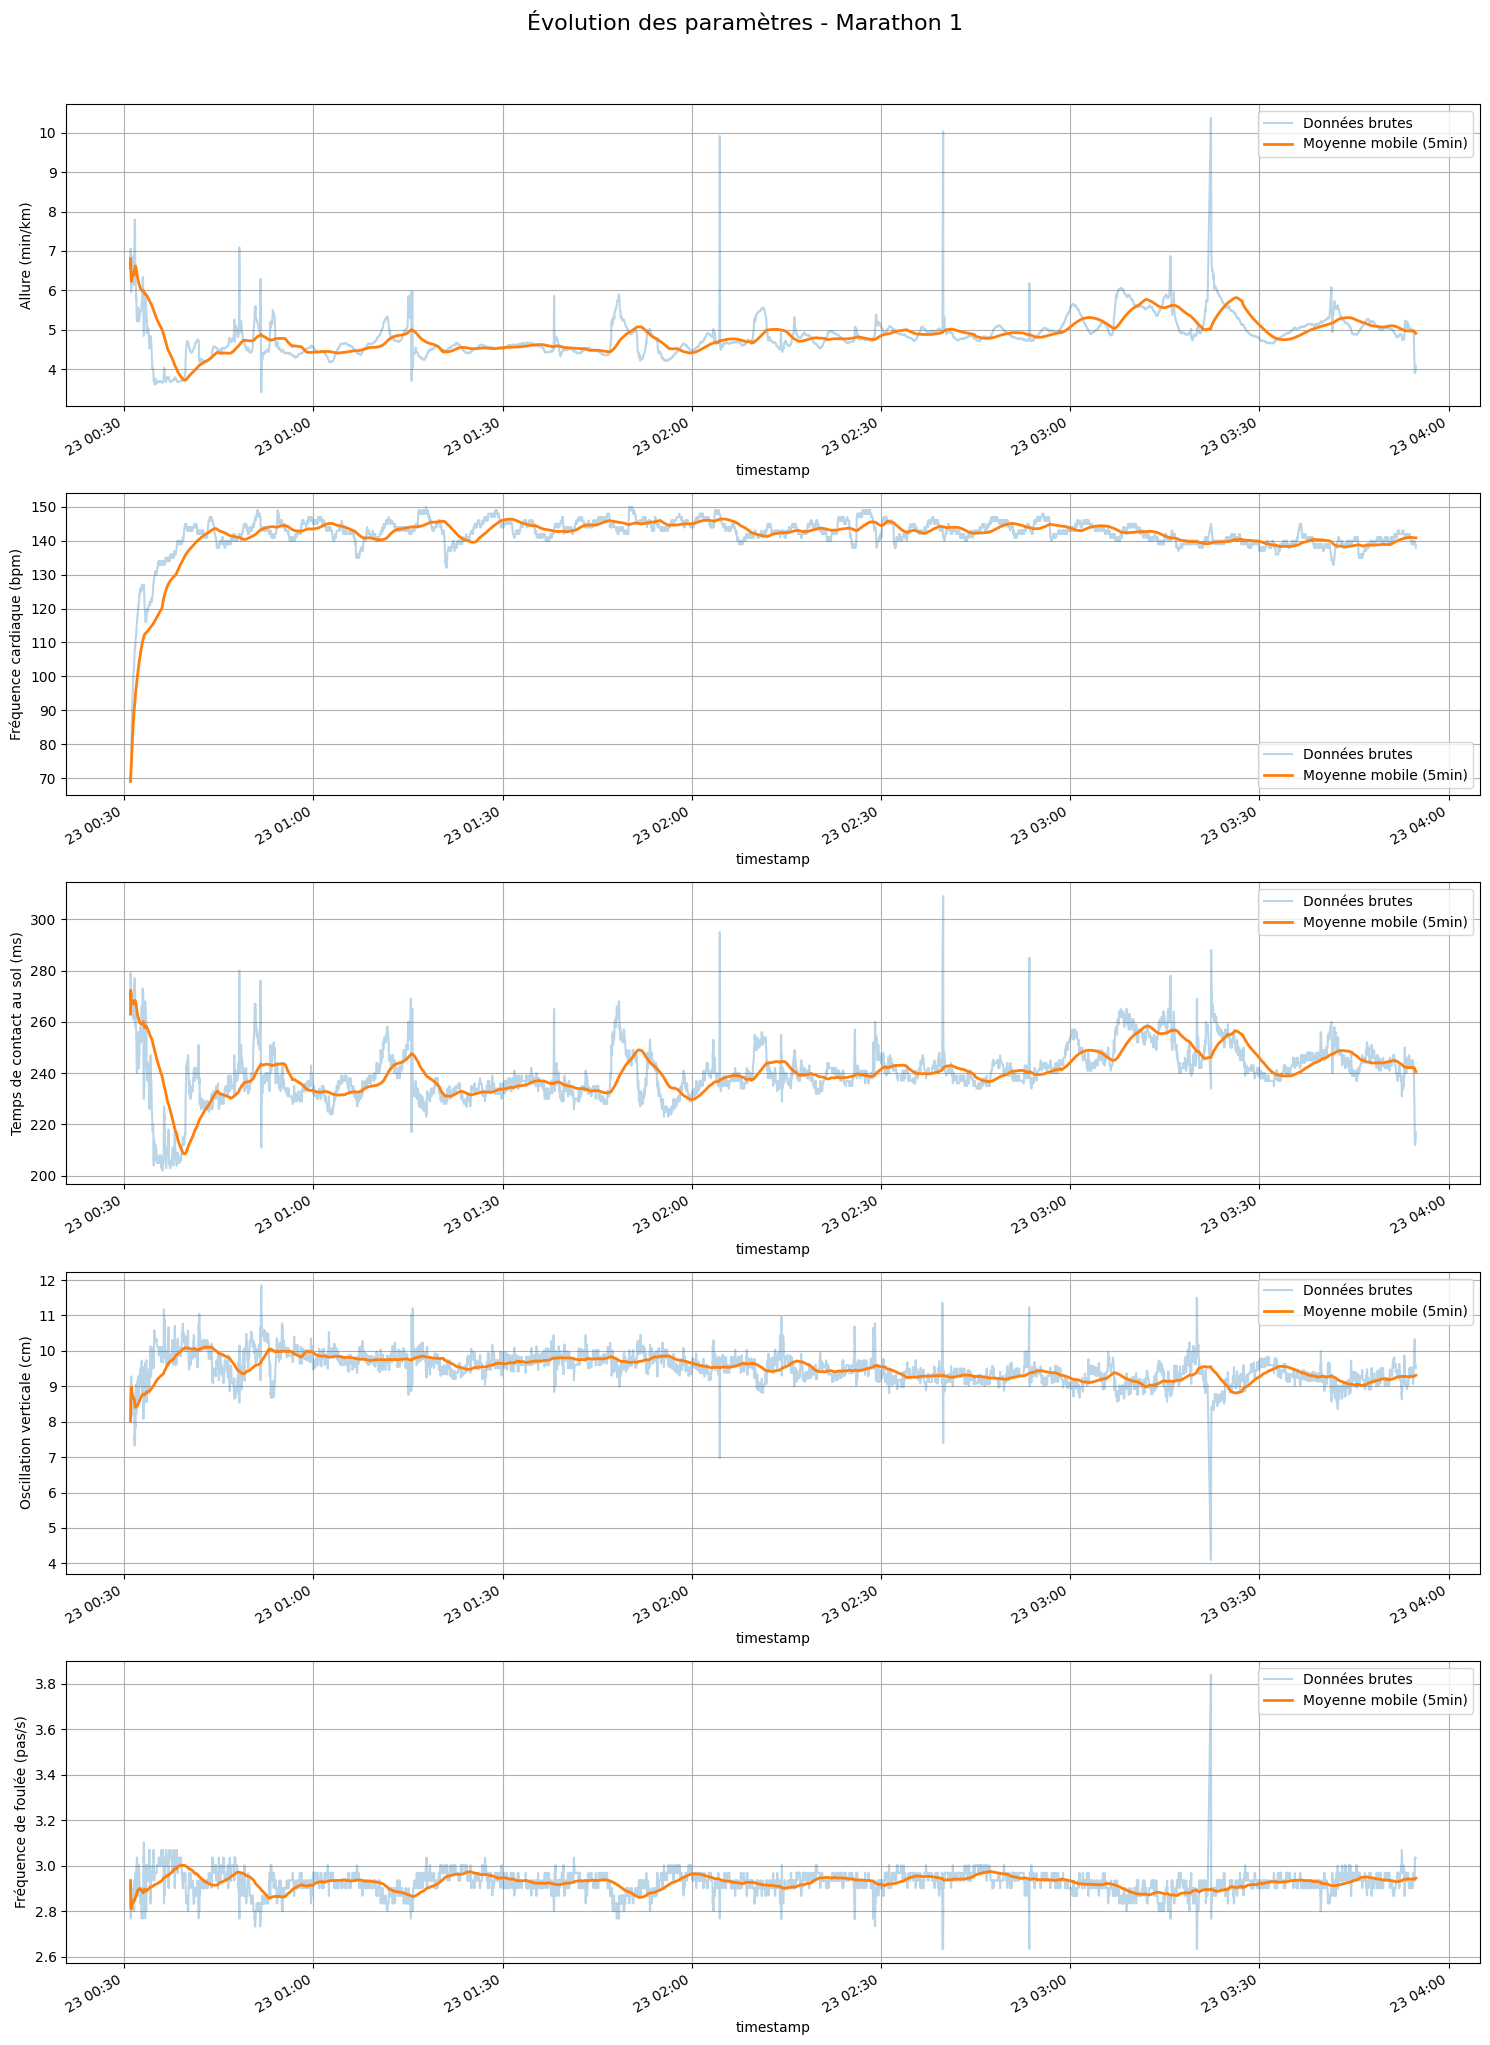

In [ ]:
def plot_temporal_evolution(ts, course_name, window='5min'):
    """
    Trace l'évolution temporelle des paramètres clés avec moyenne mobile
    """
    params = {
        'pace': 'Allure (min/km)',
        'heart_rate': 'Fréquence cardiaque (bpm)',
        'stance_time': 'Temps de contact au sol (ms)',
        'vertical_oscillation': 'Oscillation verticale (cm)',
        'stride_frequency': 'Fréquence de foulée (pas/s)'
    }
    
    fig, axes = plt.subplots(len(params), 1, figsize=(15, 4*len(params)))
    fig.suptitle(f'Évolution des paramètres - {course_name}', y=1.02, size=16)
    
    for (param, title), ax in zip(params.items(), axes):
        ts[param].plot(alpha=0.3, label='Données brutes', ax=ax)
        ts[param].rolling(window=window).mean().plot(linewidth=2, label=f'Moyenne mobile ({window})', ax=ax)
        ax.set_ylabel(title)
        ax.legend()
        ax.grid(True)
    plt.tight_layout()
    plt.show()

plot_temporal_evolution(time_series['Marathon 1'], 'Marathon 1')
plot_temporal_evolution(time_series['Marathon 2'], 'Marathon 2')
plot_temporal_evolution(time_series['Semi 1'], 'Semi 1')
plot_temporal_evolution(time_series['Semi 2'], 'Semi 2')
plot_temporal_evolution(time_series['Semi 3'], 'Semi 3')
plot_temporal_evolution(time_series['Dix 1'], 'Dix 1')
plot_temporal_evolution(time_series['Dix 2'], 'Dix 2')

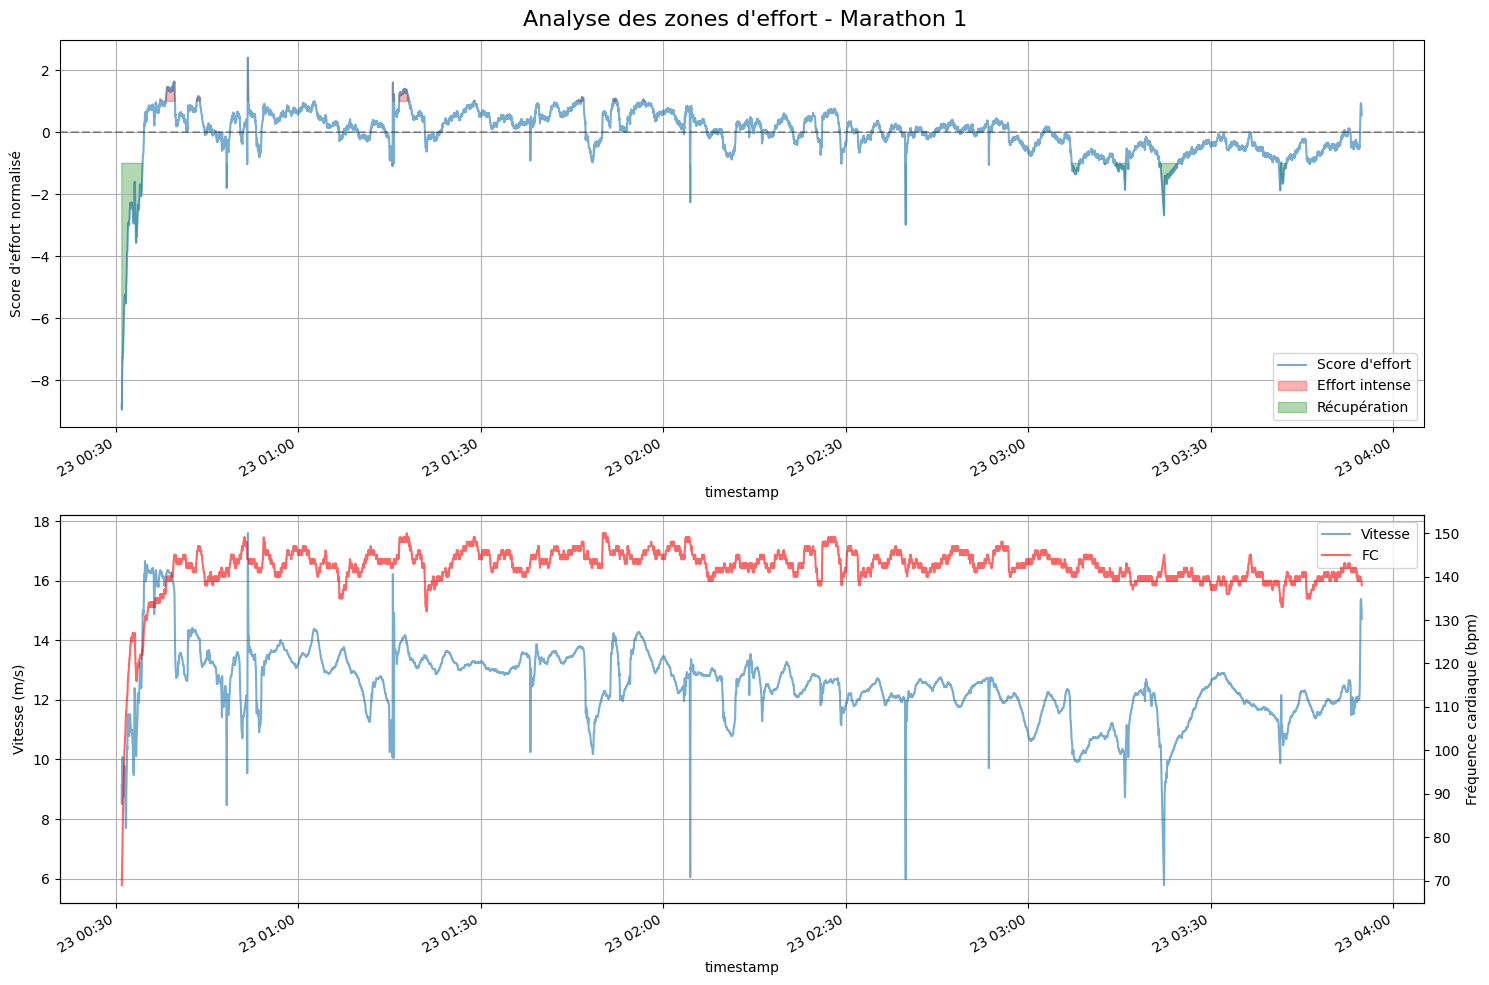


📊 Statistiques des zones d'effort
                Durée (min)  Pourcentage
Effort intense         5.65         2.79
Récupération          10.47         5.18


In [ ]:
# Détection des zones d'effort à partir de la fréquence cardiaque et de l'allure
def detect_effort_zones(ts, course_name):
    """
    Détecte les zones d'effort basées sur la fréquence cardiaque et la vitesse
    """
    # On normalise les paramètres pour éviter des valeurs trop élevées
    hr_zscore = (ts['heart_rate'] - ts['heart_rate'].mean()) / ts['heart_rate'].std()
    speed_zscore = (ts['enhanced_speed'] - ts['enhanced_speed'].mean()) / ts['enhanced_speed'].std()
    
    # On crée le score en faisant une moyenne des deux scores
    effort_score = (hr_zscore + speed_zscore) / 2
    
    # On définit les seuils - à adapter selon les ressentis d'Anto
    high_effort = effort_score > 1.0
    low_effort = effort_score < -1.0
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    fig.suptitle(f'Analyse des zones d\'effort - {course_name}', size=16)
    
    # 1er graphique : Score d'effort
    effort_score.plot(ax=ax1, alpha=0.6, label='Score d\'effort')
    ax1.fill_between(effort_score.index, effort_score.where(high_effort), 1.0,color='red', alpha=0.3, label='Effort intense')
    ax1.fill_between(effort_score.index, effort_score.where(low_effort), -1.0,color='green', alpha=0.3, label='Récupération')
    ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax1.set_ylabel('Score d\'effort normalisé')
    ax1.legend()
    ax1.grid(True)
    
    # 2ème graphique : Paramètres physiques
    ts['enhanced_speed'].plot(ax=ax2, label='Vitesse', alpha=0.6)
    ax2_hr = ax2.twinx()
    ts['heart_rate'].plot(ax=ax2_hr, color='red', label='FC', alpha=0.6)
    ax2.set_ylabel('Vitesse (m/s)')
    ax2_hr.set_ylabel('Fréquence cardiaque (bpm)')
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_hr.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
    
    stats = pd.DataFrame({
        'Durée (min)': [high_effort.sum() / 60, low_effort.sum() / 60],
        'Pourcentage': [high_effort.mean() * 100, low_effort.mean() * 100]
    }, index=['Effort intense', 'Récupération'])
    
    print("\n Statistiques des zones d'effort")
    print(stats.round(2))
    return stats

effort_stats = detect_effort_zones(time_series['Marathon 1'], 'Marathon 1')
effort_stats = detect_effort_zones(time_series['Marathon 2'], 'Marathon 2')
effort_stats = detect_effort_zones(time_series['Semi 1'], 'Semi 1')
effort_stats = detect_effort_zones(time_series['Semi 2'], 'Semi 2')
effort_stats = detect_effort_zones(time_series['Semi 3'], 'Semi 3')
effort_stats = detect_effort_zones(time_series['Dix 1'], 'Dix 1')
effort_stats = detect_effort_zones(time_series['Dix 2'], 'Dix 2')


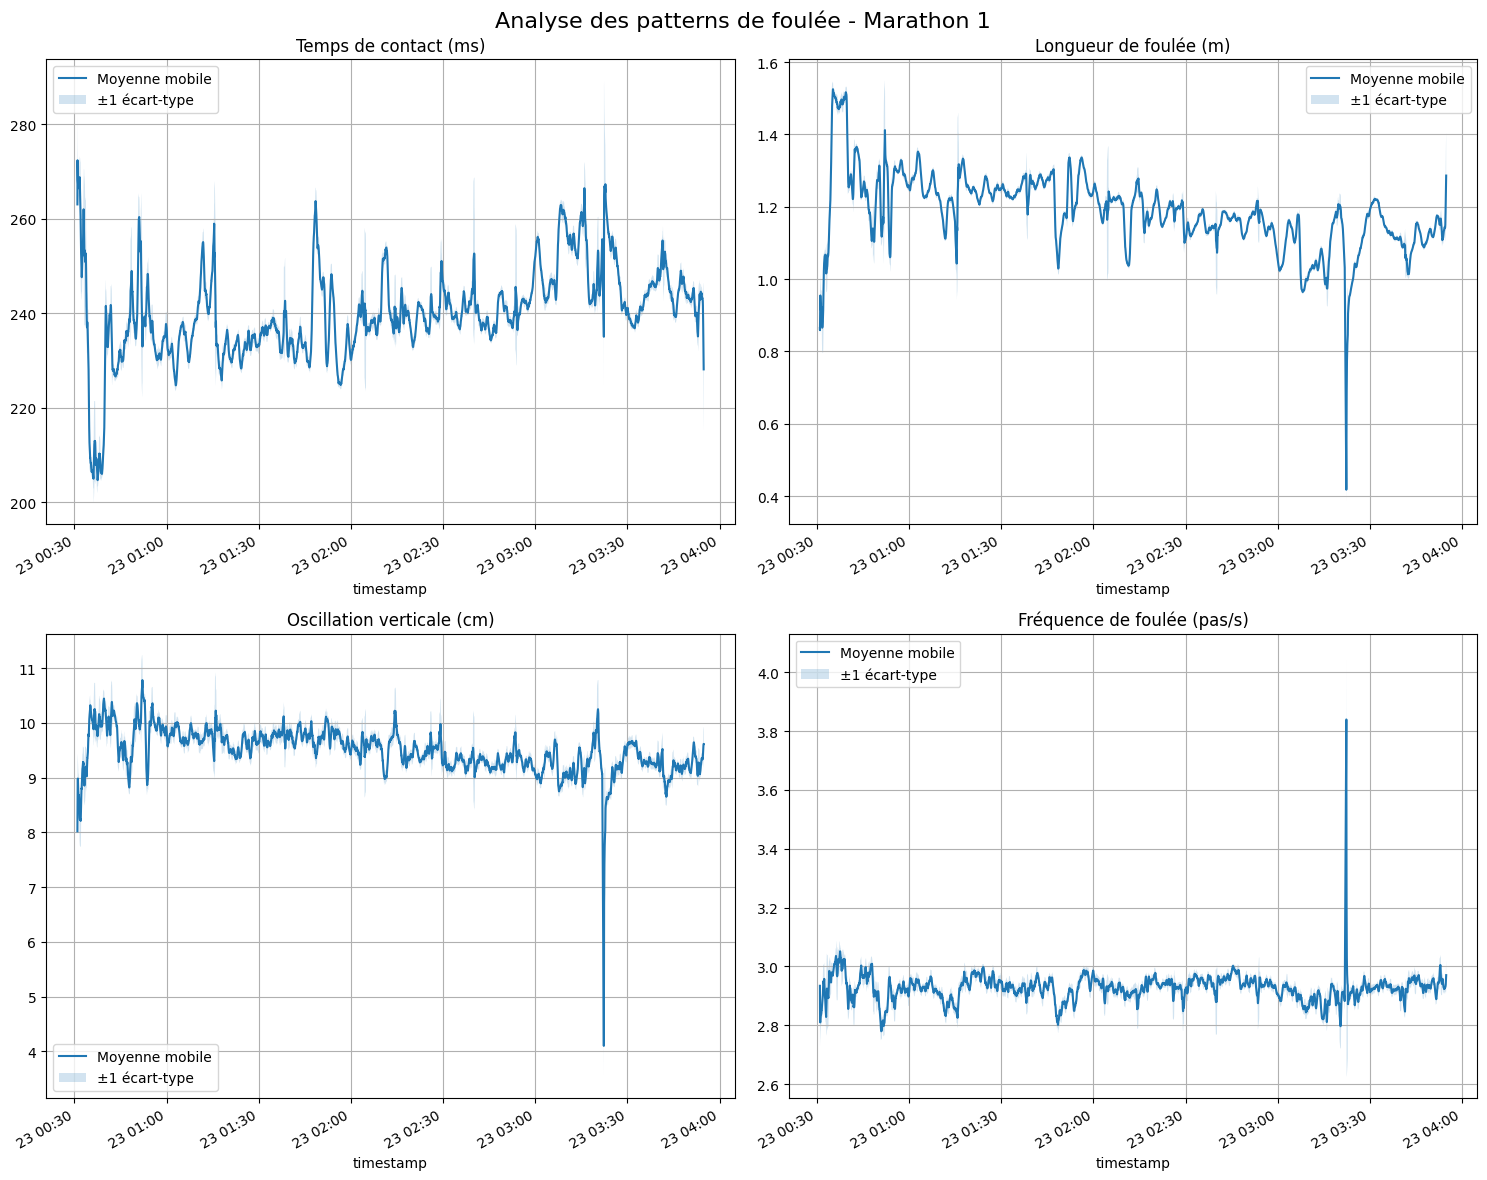


📊 Statistiques des patterns de foulée
       stance_time  step_length  vertical_oscillation  stride_frequency
count    12131.000    12131.000             12131.000         12131.000
mean       240.030        1.188                 9.506             2.926
std          9.931        0.102                 0.400             0.048
min        202.000        0.418                 4.100             2.633
25%        235.000        1.132                 9.240             2.901
50%        239.000        1.188                 9.500             2.934
75%        245.000        1.248                 9.770             2.967
max        309.000        1.746                11.850             3.840


In [ ]:
#Analyse des patterns de foulée

def analyze_stride_patterns(ts, course_name, window='30s'):
    """
    Analyse les patterns de foulée et leur variabilité
    """
    stride_metrics = pd.DataFrame({
        'stance_time': ts['stance_time'],
        'step_length': ts['step_length'],
        'vertical_oscillation': ts['vertical_oscillation'],
        'stride_frequency': ts['stride_frequency']
    })
    
    # On calcule les stratistiques en moving, avec par défaut 30 secondes mais à tester
    rolling_stats = stride_metrics.rolling(window=window).agg(['mean', 'std'])
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Analyse des patterns de foulée - {course_name}', size=16)
    
    metrics = list(stride_metrics.columns)
    titles = ['Temps de contact (ms)', 'Longueur de foulée (m)', 'Oscillation verticale (cm)', 'Fréquence de foulée (pas/s)']
    
    for (metric, title), ax in zip(zip(metrics, titles), axes.flat):
        rolling_stats[metric]['mean'].plot(ax=ax, label='Moyenne mobile')
        # Intervalle de confiance basé sur la moyenne +/- écart-type
        ax.fill_between(rolling_stats.index,
                       rolling_stats[metric]['mean'] - rolling_stats[metric]['std'],
                       rolling_stats[metric]['mean'] + rolling_stats[metric]['std'],
                       alpha=0.2, label='±1 écart-type')
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("\n Statistiques des patterns de foulée")
    stats = stride_metrics.describe()
    print(stats.round(3))
    return stats

stride_stats = analyze_stride_patterns(time_series['Marathon 1'], 'Marathon 1')
stride_stats = analyze_stride_patterns(time_series['Marathon 2'], 'Marathon 2')
stride_stats = analyze_stride_patterns(time_series['Semi 1'], 'Semi 1')
stride_stats = analyze_stride_patterns(time_series['Semi 2'], 'Semi 2')
stride_stats = analyze_stride_patterns(time_series['Semi 3'], 'Semi 3')
stride_stats = analyze_stride_patterns(time_series['Dix 1'], 'Dix 1')
stride_stats = analyze_stride_patterns(time_series['Dix 2'], 'Semi 2')

### Tentative de prédiction

C:\Users\mathi\AppData\Local\Temp\ipykernel_17084\4264422724.py:13: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resampled = ts.resample('30S').agg({



📊 Performance du modèle de prévision (enhanced_speed)
Données agrégées par 30 secondes sur 10 minutes d'historique
Nombre total d'échantillons d'entraînement : 309
R² sur l'entraînement : 0.961
R² sur le test : 0.864
RMSE sur le test : 0.342 m/s

📊 Statistiques des vitesses dans les données:
count    408.000000
mean      12.510475
std        1.125910
min        8.003167
25%       11.933783
50%       12.541433
75%       13.193450
max       16.320500
Name: enhanced_speed, dtype: float64


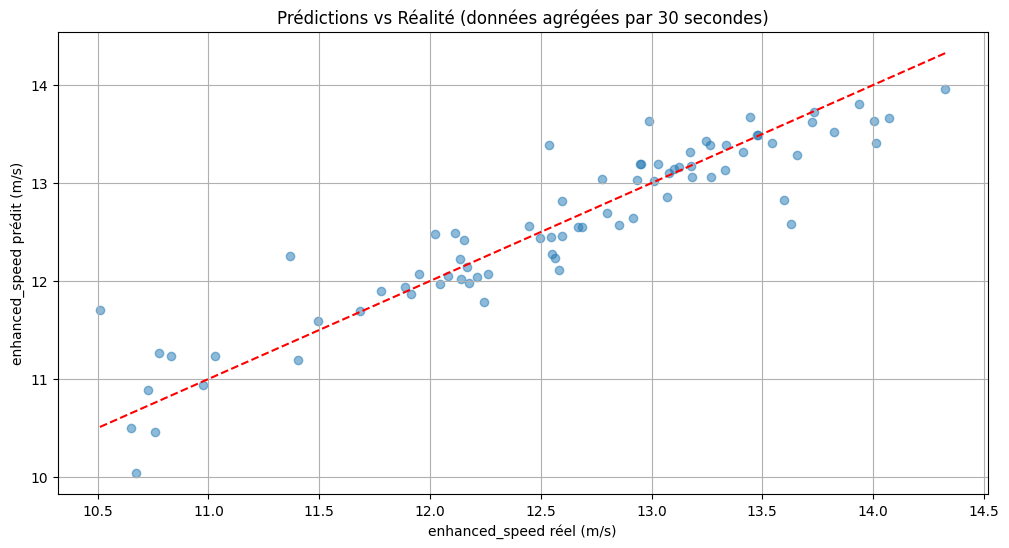


🔍 Top 10 variables les plus importantes :
                   Feature  Importance
119              pace_t-19    0.438298
117              pace_t-17    0.337114
115              pace_t-15    0.053835
86   enhanced_altitude_t-6    0.007155
116              pace_t-16    0.005460
104               pace_t-4    0.003686
32        stance_time_t-12    0.003331
33        stance_time_t-13    0.003281
111              pace_t-11    0.003149
113              pace_t-13    0.002935


In [ ]:
def predict_performance(ts, target='enhanced_speed', history_minutes=10):
    """
    Crée un modèle de prévision des performances basé sur l'historique récent
    avec agrégation par 30 secondes pour réduire le bruit
    """
    resampled = ts.resample('30S').agg({
        'heart_rate': 'mean',
        'stance_time': 'mean',
        'vertical_oscillation': 'mean',
        'step_length': 'mean',
        'enhanced_speed': 'mean',
        'enhanced_altitude': 'mean',
        'pace': 'mean'
    }).dropna()
    features = ['heart_rate', 'stance_time', 'vertical_oscillation', 
               'step_length', 'enhanced_altitude', 'pace']
    X = []
    y = []
    history_periods = history_minutes * 2
    data = resampled[features + [target]].values
    for i in range(history_periods, len(data) - 1):
        X.append(data[i-history_periods:i, :-1].flatten())  
        y.append(data[i, -1])    
    X = np.array(X)
    y = np.array(y)
    if len(X) == 0:
        raise ValueError("Pas assez de données pour l'entraînement après agrégation")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        random_state=42
    )
    model.fit(X_train_scaled, y_train)
    
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    
    print(f"\n📊 Performance du modèle de prévision ({target})")
    print(f"Données agrégées par 30 secondes sur {history_minutes} minutes d'historique")
    print(f"Nombre total d'échantillons d'entraînement : {len(X_train)}")
    print(f"R² sur l'entraînement : {train_score:.3f}")
    print(f"R² sur le test : {test_score:.3f}")
    
    rmse_test = np.sqrt(np.mean((model.predict(X_test_scaled) - y_test) ** 2))
    print(f"RMSE sur le test : {rmse_test:.3f} m/s")
    
    print("\n Statistiques des vitesses dans les données:")
    speed_stats = resampled['enhanced_speed'].describe()
    print(speed_stats)
    
    importance = pd.DataFrame({
        'Feature': [f"{feat}_t-{i}" for feat in features for i in range(history_periods)],
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    y_pred = model.predict(X_test_scaled)
    
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel(f'{target} réel (m/s)')
    plt.ylabel(f'{target} prédit (m/s)')
    plt.title('Prédictions vs Réalité (données agrégées par 30 secondes)')
    plt.grid(True)
    plt.show()
    
    print("\n🔍 Top 10 variables les plus importantes :")
    print(importance.head(10))
    
    return model, scaler, importance, resampled

#Temps d'historique de 10 minutes par défaut mais modifiable
model, scaler, importance, resampled_data = predict_performance(time_series['Marathon 1'], history_minutes=10)
model, scaler, importance, resampled_data = predict_performance(time_series['Marathon 2'], history_minutes=10)
model, scaler, importance, resampled_data = predict_performance(time_series['Semi 1'], history_minutes=10)
model, scaler, importance, resampled_data = predict_performance(time_series['Semi 2'], history_minutes=10)
model, scaler, importance, resampled_data = predict_performance(time_series['Semi 3'], history_minutes=10)
model, scaler, importance, resampled_data = predict_performance(time_series['Dix 1'], history_minutes=10)
model, scaler, importance, resampled_data = predict_performance(time_series['Dix 2'], history_minutes=10)

In [ ]:
#Fonction de prédiction en fonction d'une distance attendu ou d'un temps demandé
def predict_future_performance(ts, model, scaler, distance_km=None, minutes=None):
    """
    Prédit les performances futures sur une distance ou une durée donnée
    en utilisant les données agrégées par 30 secondes
    """
    last_data = ts.resample('30S').agg({
        'heart_rate': 'mean',
        'stance_time': 'mean',
        'vertical_oscillation': 'mean',
        'step_length': 'mean',
        'enhanced_altitude': 'mean',
        'pace': 'mean'
    }).dropna()
    
    features = ['heart_rate', 'stance_time', 'vertical_oscillation', 
                'step_length', 'enhanced_altitude', 'pace']
    
    # Définition de la période de contexte d'historique
    recent_data = last_data[features].iloc[-20:].values.flatten()
    
    # Mise à l'échelle des données
    X_pred = scaler.transform(recent_data.reshape(1, -1))
    
    predicted_speed = model.predict(X_pred)[0]
    
    # Contraintes sur la vitesse prédite basées sur les statistiques historiques
    speed_stats = ts['enhanced_speed'].describe()
    min_speed = speed_stats['25%']  
    max_speed = speed_stats['75%']  
    # Application des contraintes
    predicted_speed = np.clip(predicted_speed, min_speed, max_speed)
    
    # Calculs des métriques
    pace = 60 / predicted_speed  # min/km 
    
    if distance_km:
        estimated_time = pace * distance_km  
        hours = int(estimated_time // 60)
        minutes_part = int(estimated_time % 60)
        seconds = int((estimated_time * 60) % 60)
        
        print(f"\n🎯 Prédiction pour les prochains {distance_km} km:")
        print(f"Vitesse moyenne prédite: {predicted_speed:.2f} km/h ({pace:.2f} min/km)")
        print(f"Temps estimé: {hours:02d}:{minutes_part:02d}:{seconds:02d}")
        
    if minutes:
        distance = (predicted_speed * minutes) / 60 
        
        print(f"\n🎯 Prédiction pour les prochaines {minutes} minutes:")
        print(f"Vitesse moyenne prédite: {predicted_speed:.2f} km/h ({pace:.2f} min/km)")
        print(f"Distance estimée: {distance:.2f} km")

    print("\n📊 Contexte de la prédiction:")
    print(f"Vitesse moyenne historique: {ts['enhanced_speed'].mean():.2f} km/h")
    print(f"Vitesse minimale acceptable: {min_speed:.2f} km/h")
    print(f"Vitesse maximale acceptable: {max_speed:.2f} km/h")
    print("\n📊 Moyennes des 5 dernières minutes utilisées:")
    for feat in features:
        print(f"{feat}: {last_data[feat].iloc[-10:].mean():.2f}")

print("📊 Prédictions basées sur les dernières données du Marathon 1 (agrégées par 30 secondes):")
predict_future_performance(time_series['Marathon 1'], model, scaler, distance_km=3)
predict_future_performance(time_series['Marathon 1'], model, scaler, minutes=15)

print("📊 Prédictions basées sur les dernières données du Marathon 2 (agrégées par 30 secondes):")
predict_future_performance(time_series['Marathon 2'], model, scaler, distance_km=3)
predict_future_performance(time_series['Marathon 2'], model, scaler, minutes=15)

print("📊 Prédictions basées sur les dernières données du Semi 1 (agrégées par 30 secondes):")
predict_future_performance(time_series['Semi 1'], model, scaler, distance_km=3)
predict_future_performance(time_series['Semi 1'], model, scaler, minutes=15)

print("📊 Prédictions basées sur les dernières données du Semi 2 (agrégées par 30 secondes):")
predict_future_performance(time_series['Semi 2'], model, scaler, distance_km=3)
predict_future_performance(time_series['Semi 2'], model, scaler, minutes=15)

print("📊 Prédictions basées sur les dernières données du Semi 3 (agrégées par 30 secondes):")
predict_future_performance(time_series['Semi 3'], model, scaler, distance_km=3)
predict_future_performance(time_series['Semi 3'], model, scaler, minutes=15)

print("📊 Prédictions basées sur les dernières données du Dix 1 (agrégées par 30 secondes):")
predict_future_performance(time_series['Dix 1'], model, scaler, distance_km=3)
predict_future_performance(time_series['Dix 1'], model, scaler, minutes=15)

print("📊 Prédictions basées sur les dernières données du Dix 2 (agrégées par 30 secondes):")
predict_future_performance(time_series['Dix 2'], model, scaler, distance_km=3)
predict_future_performance(time_series['Dix 2'], model, scaler, minutes=15)

📊 Prédictions basées sur les dernières données du Marathon 1 (agrégées par 30 secondes):

🎯 Prédiction pour les prochains 3 km:
Vitesse moyenne prédite: 13.20 km/h (4.55 min/km)
Temps estimé: 00:13:38

📊 Contexte de la prédiction:
Vitesse moyenne historique: 12.52 km/h
Vitesse minimale acceptable: 11.92 km/h
Vitesse maximale acceptable: 13.20 km/h

📊 Moyennes des 5 dernières minutes utilisées:
heart_rate: 140.83
stance_time: 239.76
vertical_oscillation: 9.34
step_length: 1.17
enhanced_altitude: 188.82
pace: 4.87

🎯 Prédiction pour les prochaines 15 minutes:
Vitesse moyenne prédite: 13.20 km/h (4.55 min/km)
Distance estimée: 3.30 km

📊 Contexte de la prédiction:
Vitesse moyenne historique: 12.52 km/h
Vitesse minimale acceptable: 11.92 km/h
Vitesse maximale acceptable: 13.20 km/h

📊 Moyennes des 5 dernières minutes utilisées:
heart_rate: 140.83
stance_time: 239.76
vertical_oscillation: 9.34
step_length: 1.17
enhanced_altitude: 188.82
pace: 4.87


C:\Users\mathi\AppData\Local\Temp\ipykernel_17084\99844025.py:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  last_data = ts.resample('30S').agg({
C:\Users\mathi\AppData\Local\Temp\ipykernel_17084\99844025.py:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  last_data = ts.resample('30S').agg({


# 5- Simulation de performance

Cette section permet de simuler une course en définissant des paramètres biomécaniques (fréquence cardiaque, temps de contact au sol, etc.) pour prédire la vitesse et le temps sur une distance donnée.

In [18]:
def simulate_performance(model, scaler, distance_km, 
                      heart_rate=150, stance_time=250, 
                      vertical_oscillation=8, step_length=1.2,
                      enhanced_altitude=0, simulated_pace=5):
    """
    Simule une performance sur une distance donnée avec des paramètres biomécaniques définis
    
    Paramètres:
    - heart_rate: Fréquence cardiaque (bpm)
    - stance_time: Temps de contact au sol (ms)
    - vertical_oscillation: Oscillation verticale (cm)
    - step_length: Longueur de foulée (m)
    - enhanced_altitude: Altitude (m)
    - simulated_pace: Allure estimée (min/km)
    """
    # Création d'un jeu de données simulé
    simulated_data = np.array([
        heart_rate, stance_time, vertical_oscillation,
        step_length, enhanced_altitude, simulated_pace
    ])
    
    # Répétition des données pour correspondre à l'historique attendu (10 minutes)
    simulated_history = np.tile(simulated_data, 20)  # 20 périodes de 30 secondes
    
    # Mise à l'échelle des données
    X_sim = scaler.transform(simulated_history.reshape(1, -1))
    
    # Prédiction de la vitesse
    predicted_speed = model.predict(X_sim)[0]
    
    # Calcul des métriques
    pace = 60 / predicted_speed  # min/km
    total_time = pace * distance_km  # minutes totales
    
    # Conversion du temps en heures, minutes, secondes
    hours = int(total_time // 60)
    minutes = int(total_time % 60)
    seconds = int((total_time * 60) % 60)
    
    # Affichage des résultats
    print(f"\n🎯 Simulation pour {distance_km} km avec les paramètres suivants:")
    print(f"  • Fréquence cardiaque : {heart_rate} bpm")
    print(f"  • Temps de contact : {stance_time} ms")
    print(f"  • Oscillation verticale : {vertical_oscillation} cm")
    print(f"  • Longueur de foulée : {step_length} m")
    print(f"  • Altitude : {enhanced_altitude} m")
    print(f"  • Allure visée : {simulated_pace} min/km")
    
    print(f"\n📊 Résultats de la simulation:")
    print(f"  • Vitesse prédite : {predicted_speed:.2f} km/h")
    print(f"  • Allure prédite : {pace:.2f} min/km")
    print(f"  • Temps estimé : {hours:02d}:{minutes:02d}:{seconds:02d}")
    
    return predicted_speed, pace, total_time

# Exemple de simulations
print("🏃 Simulation d'un semi-marathon (21.1 km)")
print("==========================================")

# Simulation pour un rythme modéré
simulate_performance(model, scaler, 21.1,
                    heart_rate=155,
                    stance_time=240,
                    vertical_oscillation=8.5,
                    step_length=1.25,
                    simulated_pace=5.30)

print("\n🏃 Simulation d'un 10 km")
print("==========================================")

# Simulation pour un rythme plus rapide
simulate_performance(model, scaler, 10,
                    heart_rate=165,
                    stance_time=220,
                    vertical_oscillation=9.0,
                    step_length=1.35,
                    simulated_pace=4.45)

🏃 Simulation d'un semi-marathon (21.1 km)

🎯 Simulation pour 21.1 km avec les paramètres suivants:
  • Fréquence cardiaque : 155 bpm
  • Temps de contact : 240 ms
  • Oscillation verticale : 8.5 cm
  • Longueur de foulée : 1.25 m
  • Altitude : 0 m
  • Allure visée : 5.3 min/km

📊 Résultats de la simulation:
  • Vitesse prédite : 12.14 km/h
  • Allure prédite : 4.94 min/km
  • Temps estimé : 01:44:18

🏃 Simulation d'un 10 km

🎯 Simulation pour 10 km avec les paramètres suivants:
  • Fréquence cardiaque : 165 bpm
  • Temps de contact : 220 ms
  • Oscillation verticale : 9.0 cm
  • Longueur de foulée : 1.35 m
  • Altitude : 0 m
  • Allure visée : 4.45 min/km

📊 Résultats de la simulation:
  • Vitesse prédite : 13.25 km/h
  • Allure prédite : 4.53 min/km
  • Temps estimé : 00:45:16


(np.float64(13.251386852299781),
 np.float64(4.52782796765057),
 np.float64(45.2782796765057))

# 6- Comparaison des modèles de prédiction

Dans cette section, nous allons comparer deux approches différentes pour la prédiction des performances :
1. **SARIMA** (Seasonal ARIMA) : Un modèle statistique classique qui capture les tendances saisonnières
2. **LSTM** (Long Short-Term Memory) : Un réseau de neurones récurrent adapté aux séries temporelles

Pour améliorer la qualité des prédictions, nous allons combiner les données de toutes les courses disponibles.

L'objectif de cette section est de voir le modèle le plus performant mais aussi de combiner cette approche avec l'approche via simulation que nous venons de faire pour qu'Anto puisse améliorer ses performances. 

In [ ]:
def add_time_features(df):
    """
    Ajoute des caractéristiques temporelles au DataFrame
    """
    # Temps relatif depuis le début de la course (en minutes)
    df['time_elapsed'] = (df.index - df.index[0]).total_seconds() / 60
    # Caractéristiques cycliques
    df['minute_sin'] = np.sin(2 * np.pi * df.index.minute / 60)
    df['minute_cos'] = np.cos(2 * np.pi * df.index.minute / 60)
    return df

def prepare_sequences(data, seq_length=60, target_col='enhanced_speed'):
    """
    Prépare les séquences pour le LSTM (30 minutes d'historique)
    """
    X, y = [], []
    features = ['enhanced_speed', 'heart_rate', 'stance_time', 'vertical_oscillation', 
               'step_length', 'time_elapsed', 'minute_sin', 'minute_cos']
    
    for i in range(len(data) - seq_length):
        X.append(data[features].iloc[i:i+seq_length].values)
        y.append(data[target_col].iloc[i+seq_length])
    return np.array(X), np.array(y)

def create_lstm_model(input_shape):
    """
    Crée un modèle LSTM amélioré pour la prédiction
    """
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='huber', metrics=['mae'])
    return model

def compare_models_per_course(time_series, train_size=0.8, seq_length=60):
    """
    Compare les modèles SARIMA et LSTM sur chaque course individuellement
    """
    all_metrics = []
    for course_name, data in time_series.items():
        print(f"\n[INFO] Traitement de {course_name}...")
        df = data[['enhanced_speed', 'heart_rate', 'stance_time','vertical_oscillation', 'step_length']].copy()
        df = df.resample('30S').mean().dropna()
        df = add_time_features(df)
        # Vérifier qu'il y a suffisamment de données
        if len(df) < seq_length * 2:
            print(f"[ATTENTION] Pas assez de données pour {course_name}")
            continue
        # Préparation des données pour LSTM 
        scaler = StandardScaler()
        scaled_data = pd.DataFrame(
            scaler.fit_transform(df),
            columns=df.columns,
            index=df.index
        )
        
        X, y = prepare_sequences(scaled_data, seq_length)
        n_sequences = len(X)
        n_train = int(n_sequences * train_size)
        X_train, X_test = X[:n_train], X[n_train:]
        y_train, y_test = y[:n_train], y[n_train:]
        
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"[ATTENTION] Pas assez de données après split pour {course_name}")
            continue
            
        # Détermination des indices temporels pour SARIMA
        train_end_idx = df.index[n_train + seq_length - 1]
        sarima_train = df.loc[:train_end_idx]['enhanced_speed']
        sarima_test = df.loc[train_end_idx:]['enhanced_speed']
        
        # SARIMA
        try:
            sarima_model = SARIMAX(sarima_train,
                                order=(2,1,2),
                                seasonal_order=(1,1,1,12))
            sarima_results = sarima_model.fit(disp=False)
            sarima_pred = sarima_results.predict(start=sarima_test.index[0],
                                               end=sarima_test.index[-1])
        except Exception as e:
            print(f"[ATTENTION] Erreur avec SARIMA: {str(e)}")
            continue
            
        # LSTM
        lstm_model = create_lstm_model((seq_length, X.shape[2]))
        history = lstm_model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            verbose=0)
        
        # Prédictions LSTM
        lstm_pred = lstm_model.predict(X_test)
        lstm_pred = lstm_pred * scaler.scale_[df.columns.get_loc('enhanced_speed')] + \
                   scaler.mean_[df.columns.get_loc('enhanced_speed')]
        
        # Évaluation
        y_true = sarima_test.values[1:]  
        sarima_pred = sarima_pred[1:]    
        lstm_pred = lstm_pred[:len(y_true)] 
        
        if len(y_true) > 0 and len(sarima_pred) == len(y_true) and len(lstm_pred) == len(y_true):
            course_metrics = {
                'course': course_name,
                'n_samples': len(df),
                'SARIMA_MAE': mean_absolute_error(y_true, sarima_pred),
                'SARIMA_RMSE': np.sqrt(mean_squared_error(y_true, sarima_pred)),
                'LSTM_MAE': mean_absolute_error(y_true, lstm_pred),
                'LSTM_RMSE': np.sqrt(mean_squared_error(y_true, lstm_pred))
            }
            all_metrics.append(course_metrics)
            
            plt.figure(figsize=(15, 6))
            test_index = sarima_test.index[1:]
            plt.plot(test_index, y_true, label='Réel', alpha=0.7)
            plt.plot(test_index, sarima_pred, label='SARIMA', alpha=0.7)
            plt.plot(test_index, lstm_pred, label='LSTM', alpha=0.7)
            plt.title(f'Comparaison des prédictions - {course_name}')
            plt.xlabel('Temps')
            plt.ylabel('Vitesse (km/h)')
            plt.legend()
            plt.grid(True)
            plt.show()
            
            plt.figure(figsize=(10, 4))
            plt.plot(history.history['loss'], label='Entraînement')
            plt.plot(history.history['val_loss'], label='Validation')
            plt.title(f'Évolution de la perte du modèle LSTM - {course_name}')
            plt.xlabel('Epoch')
            plt.ylabel('Perte (Huber)')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print(f"[ATTENTION] Longueurs des prédictions incohérentes pour {course_name}")
            print(f"y_true: {len(y_true)}, SARIMA: {len(sarima_pred)}, LSTM: {len(lstm_pred)}")
        
    if all_metrics:
        metrics_df = pd.DataFrame(all_metrics)
        print("\n[RESULTATS] Résumé des performances par course:")
        print(metrics_df.round(3))
        
        print("\n[RESULTATS] Moyennes globales:")
        mean_metrics = metrics_df[['SARIMA_MAE', 'SARIMA_RMSE', 
                                 'LSTM_MAE', 'LSTM_RMSE']].mean()
        print(mean_metrics.round(3))
        return metrics_df
    else:
        print("[ATTENTION] Aucune métrique n'a pu être calculée")
        return None

print("[INFO] Lancement de la comparaison des modèles course par course...")
metrics_by_course = compare_models_per_course(time_series)

[INFO] Lancement de la comparaison des modèles course par course...

[INFO] Traitement de Marathon 1...
  * Entraînement SARIMA...


C:\Users\mathi\AppData\Local\Temp\ipykernel_17084\3645625638.py:65: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df = df.resample('30S').mean().dropna()


  * Entraînement LSTM...


c:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

## Modèle Hybride LSTM-SARIMA avec Attention

Du fait de l'échec de nos précédents essais sur de la prédiction via LSTM, nous essayons un modèle hybride qui combine :
1. Un modèle LSTM avec mécanisme d'attention
2. Un modèle SARIMA pour capturer les tendances saisonnières
3. L'intégration du dénivelé comme variable explicative supplémentaire

Nous utilisons cette approche pour :
- Capturer les dépendances à long terme avec l'attention
- Modéliser les tendances saisonnières avec SARIMA
- Prendre en compte l'impact du terrain sur les performances

In [ ]:
class AttentionLayer(tf.keras.layers.Layer):
    """
    Couche d'attention personnalisée pour le modèle LSTM
    """
    def __init__(self, units):
        super(AttentionLayer, self).__init__()
        self.attention = MultiHeadAttention(num_heads=4, key_dim=units)
        self.layernorm = LayerNormalization(epsilon=1e-6)
    
    def call(self, inputs):
        attention_output = self.attention(inputs, inputs)
        return self.layernorm(inputs + attention_output)

def create_hybrid_lstm_model(input_shape, n_features):
    """
    Crée un modèle LSTM avec attention
    """
    inputs = tf.keras.Input(shape=input_shape)
    
    #1ère couche
    x = LSTM(128, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)
    x = AttentionLayer(128)(x)
    
    #2ème couche LSTM
    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    
    #3ème couche LSTM
    x = LSTM(32)(x)
    x = Dropout(0.2)(x)
    
    #Couche finale
    x = Dense(16, activation='relu')(x)
    outputs = Dense(1)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='huber', metrics=['mae'])
    
    return model

In [ ]:
def prepare_hybrid_data(df, seq_length=60):
    """
    Prépare les données pour le modèle hybride en incluant le dénivelé
    """
    # On crée des features pour calculer le d+ et d-
    df = df.copy()
    df['altitude_change'] = df['enhanced_altitude'].diff()
    df['cumulative_elevation_gain'] = df['altitude_change'].clip(lower=0).cumsum()
    df['cumulative_elevation_loss'] = df['altitude_change'].clip(upper=0).cumsum()
    
    # On calcule une pente en % pour l'utiliser afin de mesurer l'effort
    df['slope'] = (df['altitude_change'] / (df['enhanced_speed'] * 1000/3600)) * 100
    
    # Utilisation d'une moyenne mobile
    window = '2min'
    smoothed_features = ['enhanced_speed', 'heart_rate', 'slope', 'enhanced_altitude', 'stance_time', 'step_length']
    
    for feature in smoothed_features:
        df[f'{feature}_smooth'] = df[feature].rolling(window=window, center=True).mean()
    
    features = ['enhanced_speed_smooth', 'heart_rate_smooth', 'slope_smooth',
               'enhanced_altitude', 'stance_time_smooth', 'step_length_smooth',
               'cumulative_elevation_gain', 'cumulative_elevation_loss']
    
    X, y = [], []
    for i in range(len(df) - seq_length):
        X.append(df[features].iloc[i:i+seq_length].values)
        y.append(df['enhanced_speed'].iloc[i+seq_length])
    
    return np.array(X), np.array(y), features

def combine_predictions(sarima_pred, lstm_pred, weights={'sarima': 0.3, 'lstm': 0.7}):
    """
    Combine les prédictions SARIMA et LSTM avec une pondération adaptative
    """
    # Normalisation
    total_weight = sum(weights.values())
    weights = {k: v/total_weight for k, v in weights.items()}
    
    # Combinaison pondérée
    combined_pred = (weights['sarima'] * sarima_pred + 
                    weights['lstm'] * lstm_pred)
    
    return combined_pred

In [ ]:
def evaluate_hybrid_model(time_series, course_name, train_size=0.8, seq_length=60):
    """
    Évalue le modèle hybride sur une course donnée
    """
    print(f"\n[INFO] Évaluation du modèle hybride sur {course_name}")
    
    df = time_series[course_name].copy()
    df = df.resample('30S').mean().dropna()
    
    X, y, features = prepare_hybrid_data(df, seq_length)
    
    if len(X) < seq_length * 2:
        print(f"[ATTENTION] Pas assez de données pour {course_name}")
        return None, None
    
    n_sequences = len(X)
    n_train = int(n_sequences * train_size)
    
    X_train, X_test = X[:n_train], X[n_train:]
    y_train, y_test = y[:n_train], y[n_train:]
    
    scaler = StandardScaler()
    X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
    X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
    
    X_train_scaled = scaler.fit_transform(X_train_reshaped)
    X_test_scaled = scaler.transform(X_test_reshaped)
    
    X_train_scaled = X_train_scaled.reshape(X_train.shape)
    X_test_scaled = X_test_scaled.reshape(X_test.shape)
    
    # SARIMA
    print("  * Entraînement SARIMA...")
    train_data = df.iloc[:n_train + seq_length]['enhanced_speed']
    test_data = df.iloc[n_train + seq_length:]['enhanced_speed']
    
    try:
        sarima_model = SARIMAX(train_data,
                            order=(2,1,2),
                            seasonal_order=(1,1,1,12))
        sarima_results = sarima_model.fit(disp=False)
        sarima_pred = sarima_results.forecast(steps=len(test_data))
    except Exception as e:
        print(f"[ATTENTION] Erreur SARIMA: {str(e)}")
        return None, None
    
    # LSTM avec attention
    print("  * Entraînement LSTM avec attention...")
    lstm_model = create_hybrid_lstm_model((seq_length, len(features)), len(features))
    
    history = lstm_model.fit(
        X_train_scaled, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )
    
    # Prédictions LSTM
    lstm_pred = lstm_model.predict(X_test_scaled)
    
    # Combinaison des prédictions
    print("  * Combinaison des prédictions...")
    min_len = min(len(lstm_pred), len(sarima_pred), len(test_data))
    sarima_pred = sarima_pred[:min_len]
    lstm_pred = lstm_pred[:min_len]
    y_true = test_data.iloc[:min_len]
    
    recent_window = min(10, min_len)
    sarima_recent_mae = mean_absolute_error(y_true[-recent_window:], sarima_pred[-recent_window:])
    lstm_recent_mae = mean_absolute_error(y_true[-recent_window:], lstm_pred[-recent_window:])
    
    total_error = sarima_recent_mae + lstm_recent_mae
    if total_error > 0:
        weights = {
            'sarima': 1 - (sarima_recent_mae / total_error),
            'lstm': 1 - (lstm_recent_mae / total_error)
        }
    else:
        weights = {'sarima': 0.5, 'lstm': 0.5}
    
    hybrid_pred = combine_predictions(sarima_pred, lstm_pred, weights)
    
    # Évaluation
    metrics = {
        'SARIMA_MAE': mean_absolute_error(y_true, sarima_pred),
        'SARIMA_RMSE': np.sqrt(mean_squared_error(y_true, sarima_pred)),
        'LSTM_MAE': mean_absolute_error(y_true, lstm_pred),
        'LSTM_RMSE': np.sqrt(mean_squared_error(y_true, lstm_pred)),
        'Hybrid_MAE': mean_absolute_error(y_true, hybrid_pred),
        'Hybrid_RMSE': np.sqrt(mean_squared_error(y_true, hybrid_pred))
    }
    
    plt.figure(figsize=(15, 6))
    plt.plot(test_data.index[:min_len], y_true, label='Réel', alpha=0.7)
    plt.plot(test_data.index[:min_len], sarima_pred, label='SARIMA', alpha=0.7)
    plt.plot(test_data.index[:min_len], lstm_pred, label='LSTM+Attention', alpha=0.7)
    plt.plot(test_data.index[:min_len], hybrid_pred, label='Hybride', alpha=0.7)
    plt.title(f'Comparaison des modèles - {course_name}')
    plt.xlabel('Temps')
    plt.ylabel('Vitesse (km/h)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print("\n📊 Métriques de performance:")
    for name, value in metrics.items():
        print(f"{name}: {value:.3f}")
    
    return metrics, history

In [ ]:
# Évaluation du modèle hybride sur toutes les courses disponibles

print("[INFO] Évaluation du modèle hybride sur toutes les courses disponibles...")

all_results = []
for course_name in time_series.keys():
    try:
        print(f"\nAnalyse de {course_name}...")
        metrics, _ = evaluate_hybrid_model(time_series, course_name)
        if metrics:
            metrics['course'] = course_name
            all_results.append(metrics)
    except Exception as e:
        print(f"[ERREUR] Échec pour {course_name}: {str(e)}")
        continue

if all_results:
    results_df = pd.DataFrame(all_results).set_index('course')
    
    print("\n[RÉSULTATS] Performance moyenne sur toutes les courses:")
    mean_metrics = results_df.mean()
    std_metrics = results_df.std()
    
    for metric in mean_metrics.index:
        print(f"{metric}: {mean_metrics[metric]:.3f} ± {std_metrics[metric]:.3f}")
    
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    mae_data = [results_df[f'{model}_MAE'] for model in ['SARIMA', 'LSTM', 'Hybrid']]
    plt.boxplot(mae_data, labels=['SARIMA', 'LSTM', 'Hybrid'])
    plt.title('Distribution des MAE par modèle')
    plt.ylabel('MAE (km/h)')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    rmse_data = [results_df[f'{model}_RMSE'] for model in ['SARIMA', 'LSTM', 'Hybrid']]
    plt.boxplot(rmse_data, labels=['SARIMA', 'LSTM', 'Hybrid'])
    plt.title('Distribution des RMSE par modèle')
    plt.ylabel('RMSE (km/h)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n[RÉSULTATS] Détails par course:")
    print(results_df.round(3))
else:
    print("[ATTENTION] Aucun résultat à afficher")

[INFO] Évaluation du modèle hybride sur toutes les courses disponibles...

Analyse de Marathon 1...

[INFO] Évaluation du modèle hybride sur Marathon 1


C:\Users\mathi\AppData\Local\Temp\ipykernel_17084\3364572345.py:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df = df.resample('30S').mean().dropna()


  * Entraînement SARIMA...
  * Entraînement LSTM avec attention...
  * Entraînement LSTM avec attention...
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 433ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 433ms/step
  * Combinaison des prédictions...
[ERREUR] Échec pour Marathon 1: Data must be 1-dimensional, got ndarray of shape (70, 70) instead

Analyse de Marathon 2...

[INFO] Évaluation du modèle hybride sur Marathon 2
  * Combinaison des prédictions...
[ERREUR] Échec pour Marathon 1: Data must be 1-dimensional, got ndarray of shape (70, 70) instead

Analyse de Marathon 2...

[INFO] Évaluation du modèle hybride sur Marathon 2


C:\Users\mathi\AppData\Local\Temp\ipykernel_17084\3364572345.py:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df = df.resample('30S').mean().dropna()


  * Entraînement SARIMA...


c:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837

  * Entraînement LSTM avec attention...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step
  * Combinaison des prédictions...
[ERREUR] Échec pour Marathon 2: Data must be 1-dimensional, got ndarray of shape (70, 70) instead

Analyse de Semi 1...

[INFO] Évaluation du modèle hybride sur Semi 1
  * Combinaison des prédictions...
[ERREUR] Échec pour Marathon 2: Data must be 1-dimensional, got ndarray of shape (70, 70) instead

Analyse de Semi 1...

[INFO] Évaluation du modèle hybride sur Semi 1
  * Entraînement SARIMA...
  * Entraînement SARIMA...


C:\Users\mathi\AppData\Local\Temp\ipykernel_17084\3364572345.py:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df = df.resample('30S').mean().dropna()
c:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mathi\OneDrive\Bureau\Machine Learning for time series\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will

  * Entraînement LSTM avec attention...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 856ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 856ms/step
  * Combinaison des prédictions...
[ERREUR] Échec pour Semi 1: Data must be 1-dimensional, got ndarray of shape (34, 34) instead

Analyse de Semi 2...

[INFO] Évaluation du modèle hybride sur Semi 2
  * Combinaison des prédictions...
[ERREUR] Échec pour Semi 1: Data must be 1-dimensional, got ndarray of shape (34, 34) instead

Analyse de Semi 2...

[INFO] Évaluation du modèle hybride sur Semi 2


C:\Users\mathi\AppData\Local\Temp\ipykernel_17084\3364572345.py:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df = df.resample('30S').mean().dropna()


  * Entraînement SARIMA...
  * Entraînement LSTM avec attention...
  * Entraînement LSTM avec attention...


KeyboardInterrupt: 

Echec de cette partie car erreur au niveau de la multi dimensionnalité de nos éléments. [ERREUR] Échec pour Marathon 1: Data must be 1-dimensional, got ndarray of shape (70, 70) instead


# 7- Analyse biomécanique avancée

Les objectifs de cette partie sont d'analyser un maximum les features biomécaniques que nous avons telles que :

1. **Variabilité de la Foulée (RVI)**
2. **Détection de la Fatigue**
3. **Économie de Course**

## Variabilité de la foulée

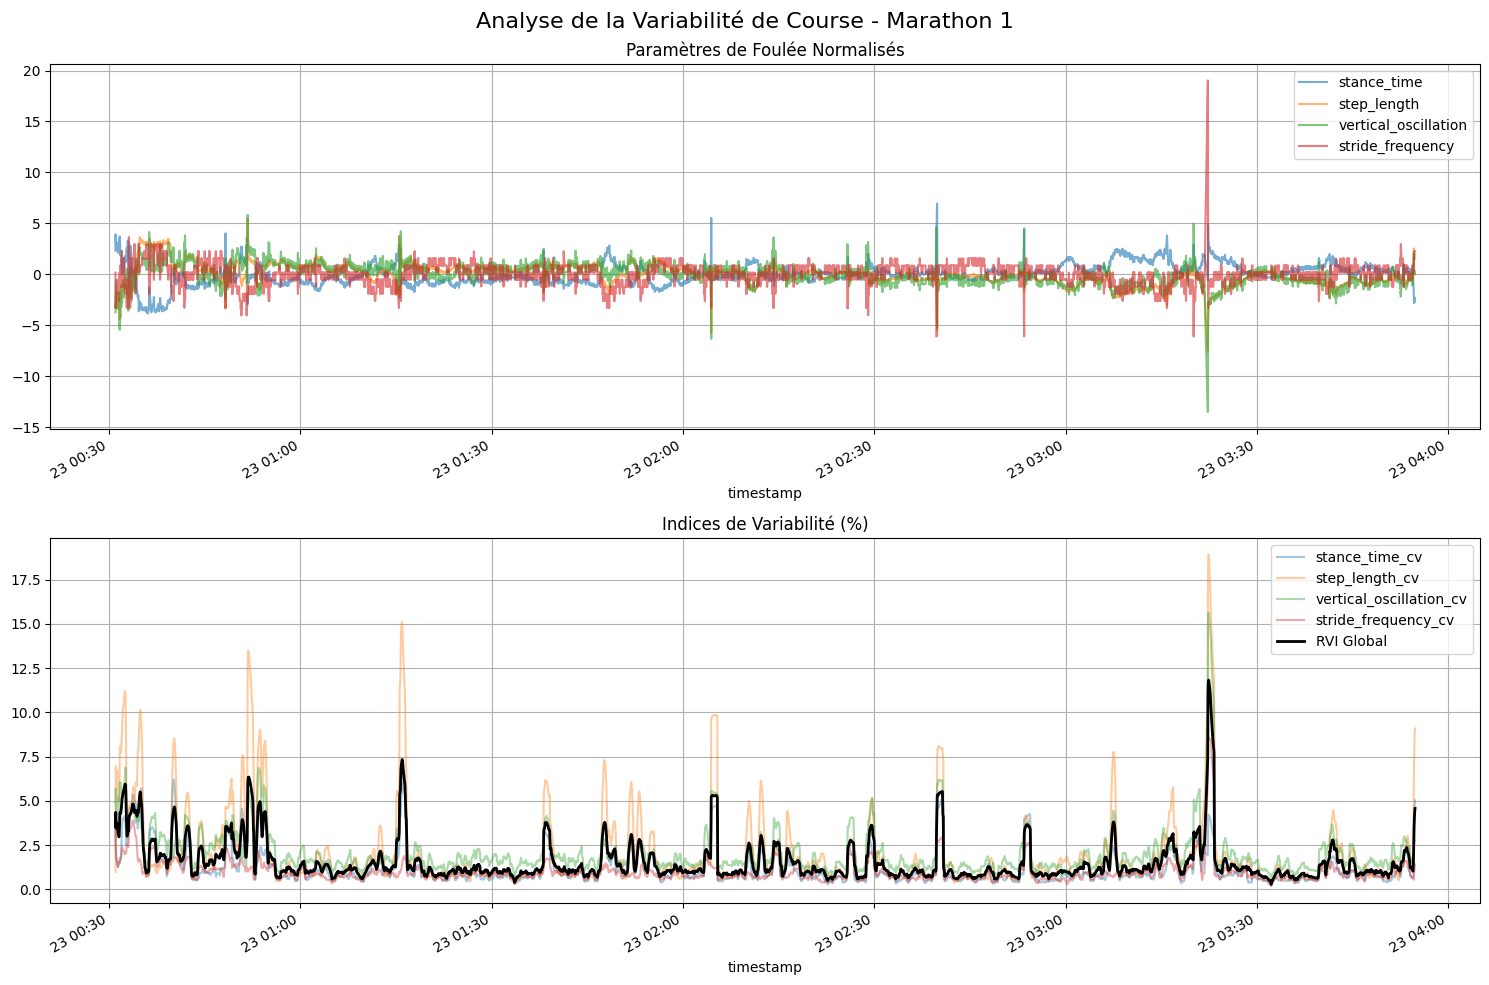


📊 Statistiques de variabilité:
       stance_time_cv  step_length_cv  vertical_oscillation_cv  \
count        12130.00        12130.00                 12130.00   
mean             1.20            1.98                     2.03   
std              1.01            2.24                     1.32   
min              0.19            0.23                     0.53   
25%              0.64            0.83                     1.33   
50%              0.83            1.15                     1.61   
75%              1.26            1.95                     2.26   
max              6.20           18.92                    15.65   

       stride_frequency_cv       RVI  
count             12130.00  12130.00  
mean                  0.98      1.55  
std                   0.67      1.20  
min                   0.26      0.30  
25%                   0.66      0.91  
50%                   0.80      1.10  
75%                   1.09      1.66  
max                   8.56     11.83  


In [ ]:
def calculate_running_variability_index(df, window='1min'):
    """
    Calcule l'indice de variabilité de la foulée (RVI)
    
    Le RVI est calculé comme la moyenne des coefficients de variation
    des paramètres clés de la foulée sur une fenêtre glissante.
    """
    # Paramètres que nous avons choisis d'analysés pour la variabilité de la foulée
    params = ['stance_time', 'step_length', 'vertical_oscillation', 'stride_frequency']
    
    # On calcule des coef de variation avec des fenêtres glissantes
    cv_dict = {}
    for param in params:
        rolling_mean = df[param].rolling(window=window).mean()
        rolling_std = df[param].rolling(window=window).std()
        cv = (rolling_std / rolling_mean) * 100
        cv_dict[f'{param}_cv'] = cv
    cv_df = pd.DataFrame(cv_dict, index=df.index)
    cv_df['RVI'] = cv_df.mean(axis=1)
    return cv_df

def plot_running_variability(df, cv_df, course_name):
    """
    Visualise la variabilité de la foulée et ses composantes
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    fig.suptitle(f'Analyse de la Variabilité de Course - {course_name}', size=16)
    
    # Plot des paramètres normalisés
    params = ['stance_time', 'step_length', 'vertical_oscillation', 'stride_frequency']
    normalized_params = {}
    for param in params:
        normalized = (df[param] - df[param].mean()) / df[param].std()
        normalized_params[param] = normalized
        normalized.plot(ax=ax1, alpha=0.6, label=param)
    
    ax1.set_title('Paramètres de Foulée Normalisés')
    ax1.legend()
    ax1.grid(True)
    
    # Plot des coefficients de variation
    for col in cv_df.columns:
        if col != 'RVI':
            cv_df[col].plot(ax=ax2, alpha=0.4, label=col)
    
    cv_df['RVI'].plot(ax=ax2, color='black', linewidth=2, label='RVI Global')
    
    ax2.set_title('Indices de Variabilité (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("\n Statistiques de variabilité:")
    stats = cv_df.describe().round(2)
    print(stats)
    return stats

course_name = list(time_series.keys())[0]  # Première course disponible
cv_df = calculate_running_variability_index(time_series[course_name])
variability_stats = plot_running_variability(time_series[course_name], cv_df, course_name)

## Détection des phases de fatigue

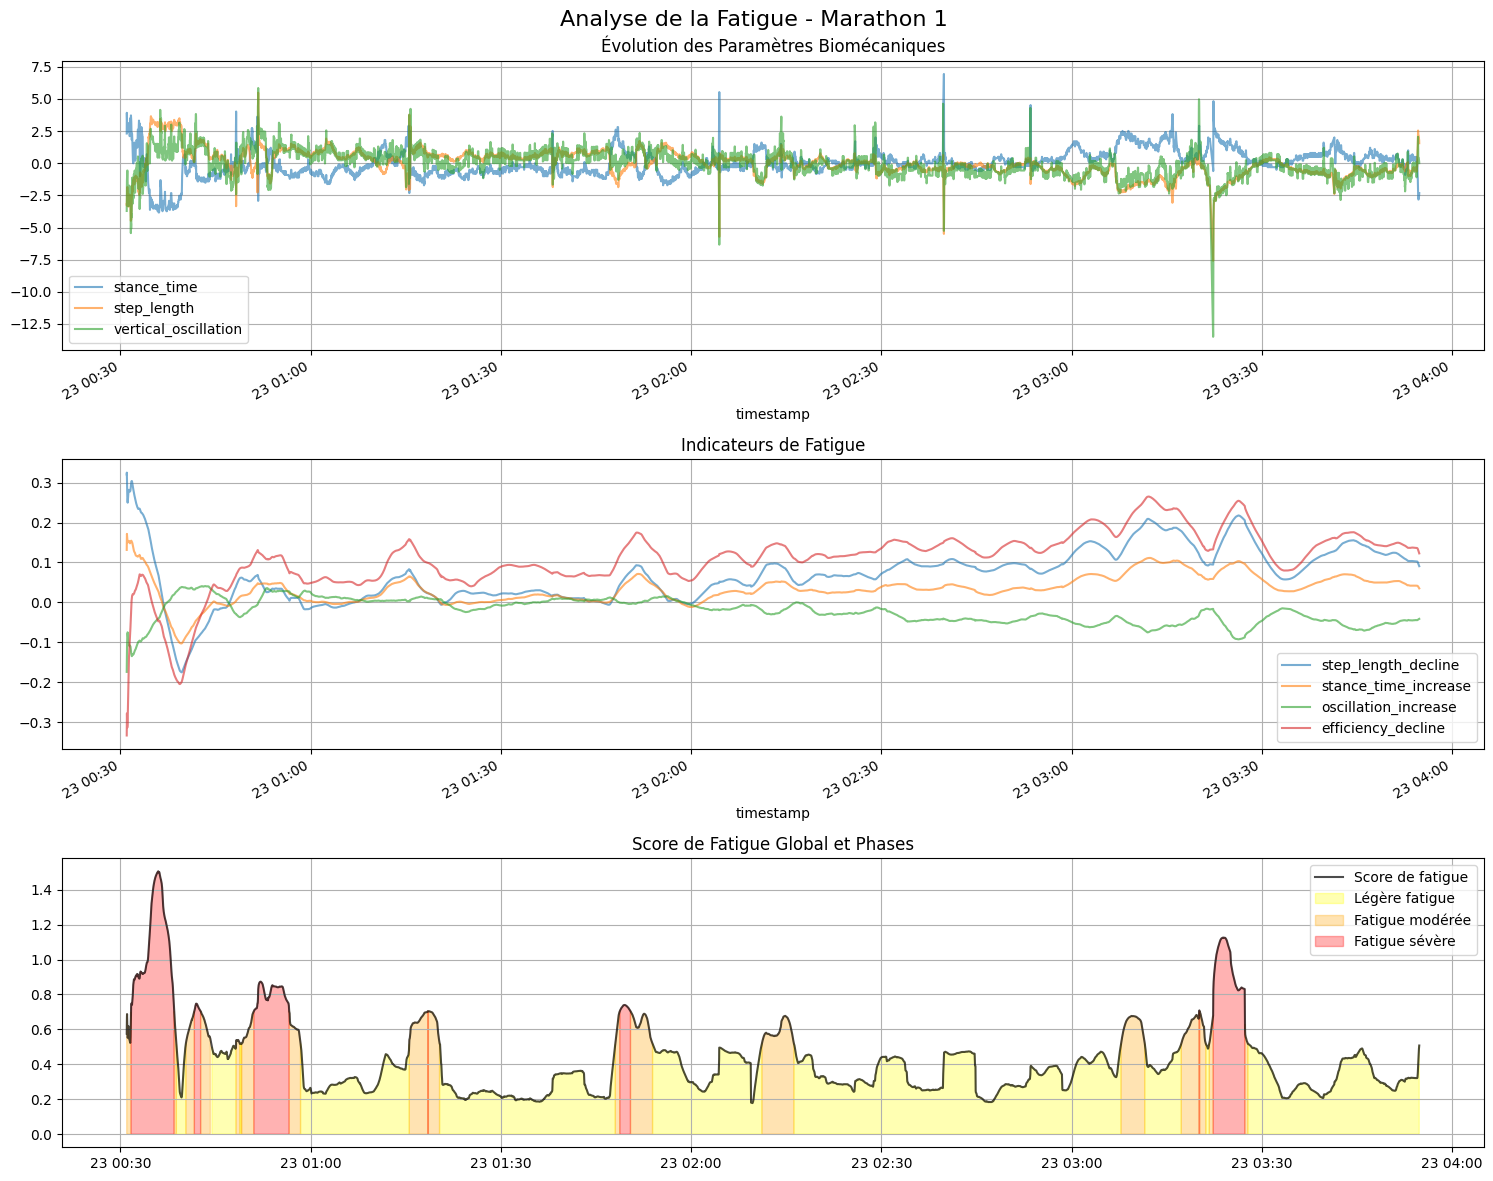


📊 Distribution des phases de fatigue:
Légère fatigue: 75.0%
Fatigue modérée: 15.0%
Fatigue sévère: 10.0%
Normal: 0.0%


In [ ]:
def detect_fatigue_phases(df, window='5min'):
    """
    Détecte automatiquement les phases de fatigue basées sur les changements
    de patterns biomécaniques
    """
    fatigue_indicators = pd.DataFrame(index=df.index)
    
    # Diminution de la longueur de foulée
    step_length_ma = df['step_length'].rolling(window=window).mean()
    step_length_baseline = df['step_length'].iloc[:int(len(df)*0.1)].mean()  # Première 10% de la course
    fatigue_indicators['step_length_decline'] = (step_length_baseline - step_length_ma) / step_length_baseline
    
    # Augmentation du temps de contact au sol
    stance_ma = df['stance_time'].rolling(window=window).mean()
    stance_baseline = df['stance_time'].iloc[:int(len(df)*0.1)].mean()
    fatigue_indicators['stance_time_increase'] = (stance_ma - stance_baseline) / stance_baseline
    
    # Augmentation de l'oscillation verticale
    oscillation_ma = df['vertical_oscillation'].rolling(window=window).mean()
    oscillation_baseline = df['vertical_oscillation'].iloc[:int(len(df)*0.1)].mean()
    fatigue_indicators['oscillation_increase'] = (oscillation_ma - oscillation_baseline) / oscillation_baseline
    
    # Utilisation RVI
    cv_df = calculate_running_variability_index(df, window=window)
    fatigue_indicators['variability_increase'] = cv_df['RVI']
    
    # Ratio vitesse/FC
    efficiency = df['enhanced_speed'] / df['heart_rate']
    efficiency_ma = efficiency.rolling(window=window).mean()
    efficiency_baseline = efficiency.iloc[:int(len(df)*0.1)].mean()
    fatigue_indicators['efficiency_decline'] = (efficiency_baseline - efficiency_ma) / efficiency_baseline
    
    # Score de fatigue global avec poids à moduler
    weights = {
        'step_length_decline': 0.25,
        'stance_time_increase': 0.25,
        'oscillation_increase': 0.15,
        'variability_increase': 0.15,
        'efficiency_decline': 0.20
    }
    
    fatigue_indicators['fatigue_score'] = sum(fatigue_indicators[indicator] * weight 
                                            for indicator, weight in weights.items())
    
    # Classification des phases
    fatigue_threshold = fatigue_indicators['fatigue_score'].quantile(0.75)  
    severe_fatigue_threshold = fatigue_indicators['fatigue_score'].quantile(0.9)  
    
    fatigue_indicators['fatigue_phase'] = pd.cut(fatigue_indicators['fatigue_score'],
                                               bins=[-np.inf, 0, fatigue_threshold, severe_fatigue_threshold, np.inf],
                                               labels=['Normal', 'Légère fatigue', 'Fatigue modérée', 'Fatigue sévère'])
    return fatigue_indicators

def plot_fatigue_analysis(df, fatigue_indicators, course_name):
    """
    Visualise l'analyse de fatigue et ses composantes
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle(f'Analyse de la Fatigue - {course_name}', size=16)
    
    # Paramètres biomécaniques normalisés
    params = ['stance_time', 'step_length', 'vertical_oscillation']
    for param in params:
        normalized = (df[param] - df[param].mean()) / df[param].std()
        normalized.plot(ax=ax1, alpha=0.6, label=param)
    
    ax1.set_title('Évolution des Paramètres Biomécaniques')
    ax1.legend()
    ax1.grid(True)
    
    # Indicateurs de fatigue individuels
    indicators = ['step_length_decline', 'stance_time_increase', 
                 'oscillation_increase', 'efficiency_decline']
    for indicator in indicators:
        fatigue_indicators[indicator].plot(ax=ax2, alpha=0.6, label=indicator)
    
    ax2.set_title('Indicateurs de Fatigue')
    ax2.legend()
    ax2.grid(True)
    
    # Score de fatigue global et phases
    fatigue_score = fatigue_indicators['fatigue_score']
    ax3.plot(fatigue_score.index, fatigue_score, 'k-', label='Score de fatigue', alpha=0.7)
    
    phase_colors = {'Normal': 'green', 'Légère fatigue': 'yellow',
                   'Fatigue modérée': 'orange', 'Fatigue sévère': 'red'}
    
    for phase in phase_colors:
        mask = (fatigue_indicators['fatigue_phase'] == phase)
        if mask.any():
            ax3.fill_between(fatigue_score.index, fatigue_score.where(mask), 
                           alpha=0.3, color=phase_colors[phase], label=phase)
    
    ax3.set_title('Score de Fatigue Global et Phases')
    ax3.legend()
    ax3.grid(True)
    plt.tight_layout()
    plt.show()
    
    phase_stats = fatigue_indicators['fatigue_phase'].value_counts()
    phase_duration = phase_stats / len(fatigue_indicators) * 100
    
    print("\n Distribution des phases de fatigue:")
    for phase, percentage in phase_duration.items():
        print(f"{phase}: {percentage:.1f}%")
    
    return phase_duration

fatigue_indicators = detect_fatigue_phases(time_series[course_name])
phase_stats = plot_fatigue_analysis(time_series[course_name], fatigue_indicators, course_name)

## Economie de course et rythme

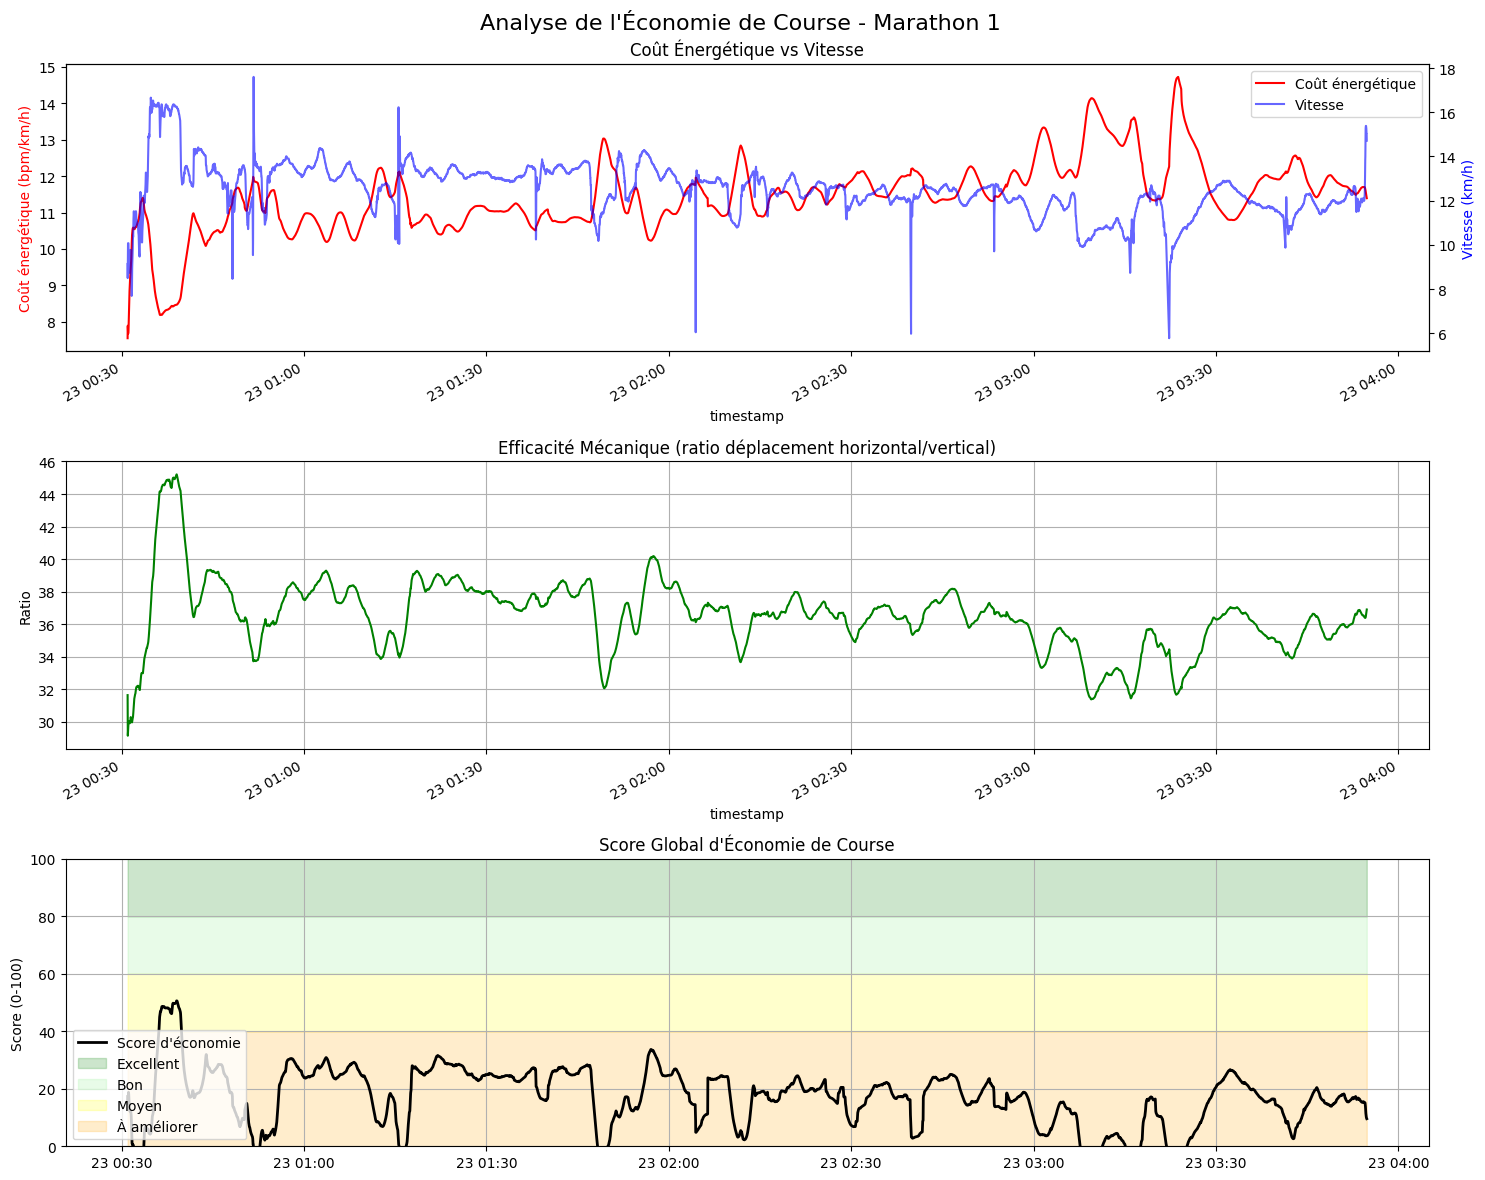


📊 Statistiques d'économie de course:
       energy_cost  mechanical_efficiency  pattern_stability  economy_score
count     12131.00               12131.00           12130.00       12130.00
mean         11.44                  36.51              98.05          16.77
std           0.95                   2.19               1.27          10.88
min           7.55                  29.15              91.77         -29.50
25%          10.91                  35.40              97.69          10.71
50%          11.42                  36.62              98.54          17.85
75%          11.93                  37.75              98.87          24.33
max          14.72                  45.21              99.39          50.62

⏱️ Temps passé dans chaque zone:
À améliorer: 98.0%
Moyen: 2.0%
Bon: 0.0%
Excellent: 0.0%


In [ ]:
def calculate_running_economy(df, window='2min'):
    """
    Calcule et analyse l'économie de course
    
    L'économie de course est évaluée à travers plusieurs métriques :
    1. Coût énergétique (ratio FC/vitesse)
    2. Efficacité mécanique (ratio déplacement horizontal/vertical)
    3. Stabilité du pattern de course
    """
    # Création du DataFrame pour l'analyse d'économie
    economy_metrics = pd.DataFrame(index=df.index)
    
    # Coût énergétique -> Plus la heart rate est basse avec une vitesse haute mieux c'est
    economy_metrics['energy_cost'] = (df['heart_rate'] / df['enhanced_speed']).rolling(window=window).mean()
    
    # Efficacité mécanique -> plus c'est haut, plus le mouvement est économique
    horizontal_displacement = df['enhanced_speed'] * 1000/3600  
    vertical_displacement = df['vertical_oscillation'] / 100 
    economy_metrics['mechanical_efficiency'] = (horizontal_displacement / vertical_displacement).rolling(window=window).mean()
    
    # Stabilité du pattern -> Utilisation RVI pour stabilité
    cv_df = calculate_running_variability_index(df, window=window)
    economy_metrics['pattern_stability'] = 100 - cv_df['RVI']  # Conversion en score positif
    
    # Score d'économie global (0-100)
    normalized_metrics = pd.DataFrame()
    for column in economy_metrics.columns:
        normalized_metrics[column] = ((economy_metrics[column] - economy_metrics[column].min()) / 
                                    (economy_metrics[column].max() - economy_metrics[column].min()) * 100)
    
    # On définit des poids selon le jugement d'Anto
    weights = {
        'energy_cost': -0.4,  #Plus c'est bas, mieux c'est
        'mechanical_efficiency': 0.3,
        'pattern_stability': 0.3
    }
    
    economy_metrics['economy_score'] = sum(normalized_metrics[metric] * weight 
                                         for metric, weight in weights.items())
    
    return economy_metrics

def plot_running_economy(df, economy_metrics, course_name):
    """
    Visualise l'analyse de l'économie de course
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle(f'Analyse de l\'Économie de Course - {course_name}', size=16)
    
    #Coût énergétique et vitesse
    ax1_twin = ax1.twinx()
    economy_metrics['energy_cost'].plot(ax=ax1, color='red', label='Coût énergétique')
    df['enhanced_speed'].plot(ax=ax1_twin, color='blue', label='Vitesse', alpha=0.6)
    
    ax1.set_ylabel('Coût énergétique (bpm/km/h)', color='red')
    ax1_twin.set_ylabel('Vitesse (km/h)', color='blue')
    ax1.set_title('Coût Énergétique vs Vitesse')
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    #Efficacité mécanique
    economy_metrics['mechanical_efficiency'].plot(ax=ax2, color='green')
    ax2.set_title('Efficacité Mécanique (ratio déplacement horizontal/vertical)')
    ax2.set_ylabel('Ratio')
    ax2.grid(True)
    
    #Score d'économie global
    score = economy_metrics['economy_score']
    ax3.plot(score.index, score, 'k-', label='Score d\'économie', linewidth=2)
    
    #Zones de perf
    zones = {
        'Excellent': (80, 100, 'green'),
        'Bon': (60, 80, 'lightgreen'),
        'Moyen': (40, 60, 'yellow'),
        'À améliorer': (0, 40, 'orange')
    }
    
    for zone_name, (min_val, max_val, color) in zones.items():
        ax3.fill_between(score.index, min_val, max_val, alpha=0.2, color=color, label=zone_name)
    
    ax3.set_title('Score Global d\'Économie de Course')
    ax3.set_ylabel('Score (0-100)')
    ax3.set_ylim(0, 100)
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("\n Statistiques d'économie de course:")
    stats = economy_metrics.describe().round(2)
    print(stats)
    
    # Répartition du temps dans les zones
    score_zones = pd.cut(score, 
                        bins=[0, 40, 60, 80, 100],
                        labels=['À améliorer', 'Moyen', 'Bon', 'Excellent'])
    zone_stats = score_zones.value_counts(normalize=True) * 100
    
    print("\n⏱️ Temps passé dans chaque zone:")
    for zone, percentage in zone_stats.items():
        print(f"{zone}: {percentage:.1f}%")
    
    return stats, zone_stats

# Analyse de l'économie de course
economy_metrics = calculate_running_economy(time_series[course_name])
economy_stats, zone_stats = plot_running_economy(time_series[course_name], economy_metrics, course_name)

# 8- Analyse Approfondie des Performances

Cette section explore trois aspects clés de la performance :

1. **Zones Personnalisées de sur et sous performance**
2. **Score de Forme**
3. **Analyse de Récupération**

## Zones de sous et sur perf

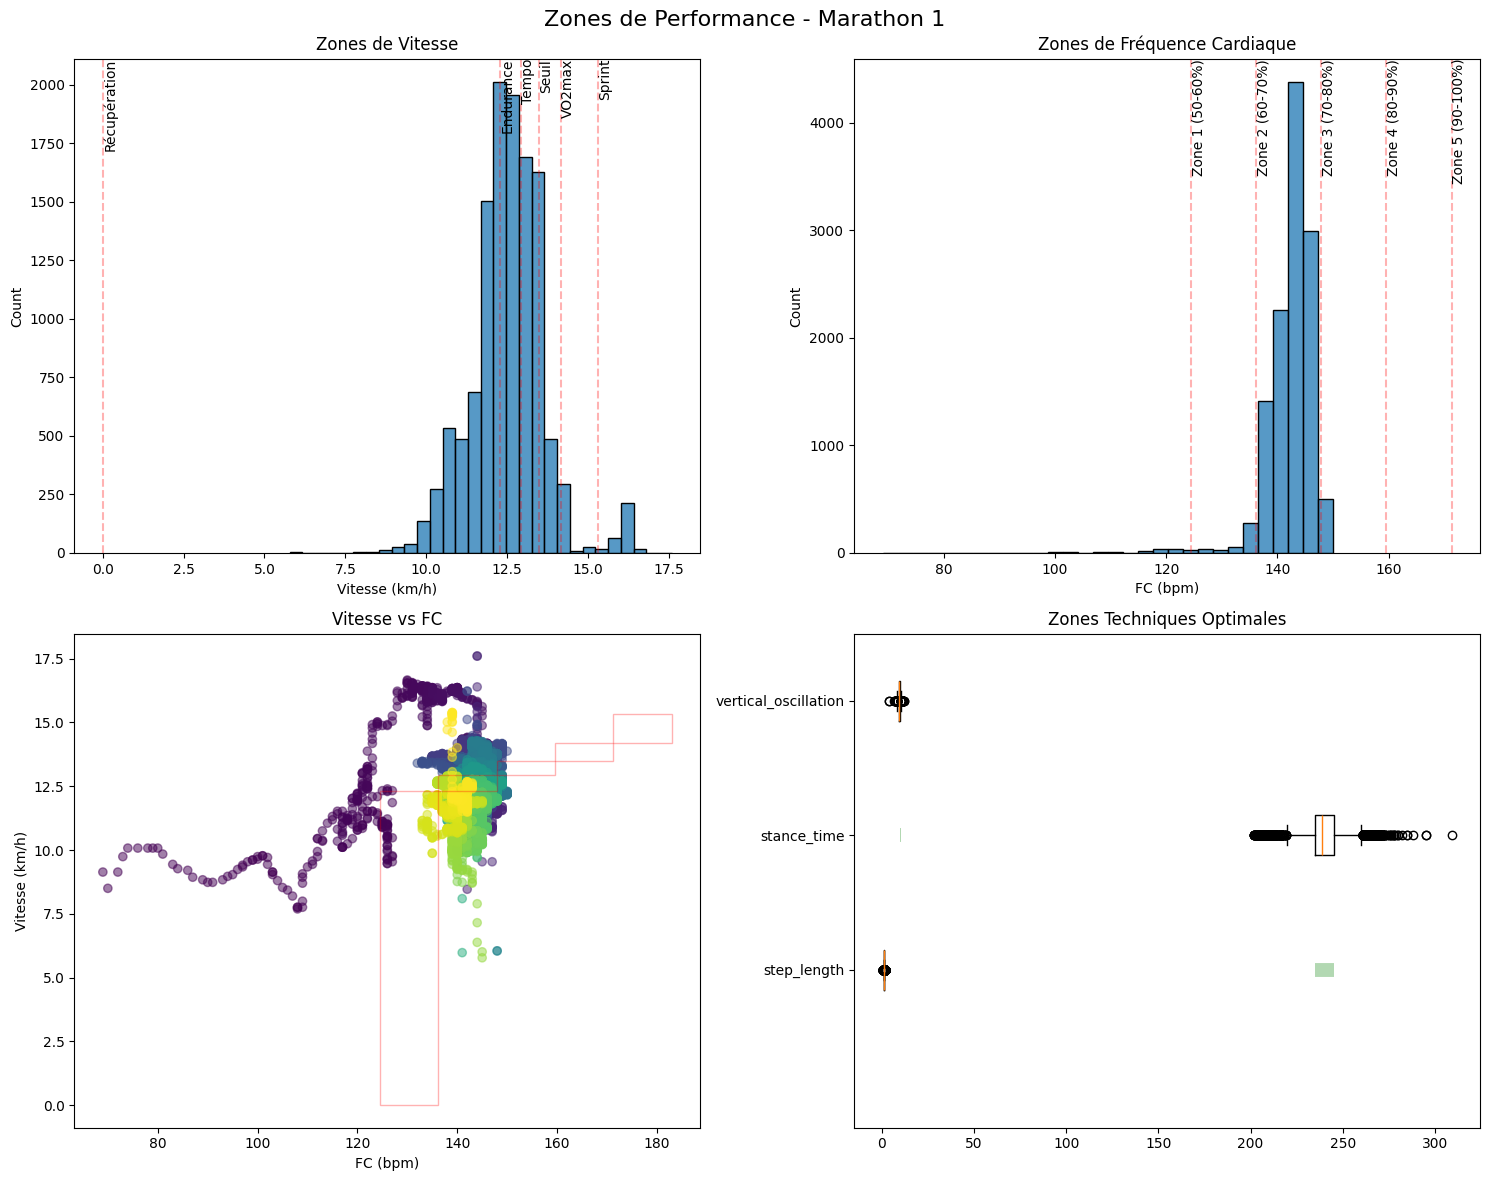


📊 Recommandations d'entraînement:

Zones de vitesse (km/h):
Récupération: 0.0 - 12.3
Endurance: 12.3 - 12.9
Tempo: 12.9 - 13.5
Seuil: 13.5 - 14.2
VO2max: 14.2 - 15.3
Sprint: 15.3 - 24.5

Zones de FC (bpm):
Zone 1 (50-60%): 124 - 136
Zone 2 (60-70%): 136 - 148
Zone 3 (70-80%): 148 - 160
Zone 4 (80-90%): 160 - 171
Zone 5 (90-100%): 171 - 183

Zones techniques optimales:
step_length: 1.24 - 1.37
stance_time: 235.00 - 245.00
vertical_oscillation: 9.78 - 10.53


In [ ]:
def calculate_performance_zones(time_series):
    """
    Calcule les zones de performance personnalisées basées sur l'historique
    """
    all_data = pd.concat([df[['enhanced_speed', 'heart_rate', 'stance_time', 
                             'step_length', 'vertical_oscillation']] 
                         for df in time_series.values()])
    
    #Zones de vitesse
    speeds = all_data['enhanced_speed'].dropna()
    speed_zones = {
        'Récupération': (0, speeds.quantile(0.2)),
        'Endurance': (speeds.quantile(0.2), speeds.quantile(0.4)),
        'Tempo': (speeds.quantile(0.4), speeds.quantile(0.6)),
        'Seuil': (speeds.quantile(0.6), speeds.quantile(0.8)),
        'VO2max': (speeds.quantile(0.8), speeds.quantile(0.95)),
        'Sprint': (speeds.quantile(0.95), speeds.max())
    }
    
    #Zones de fréquence cardiaque
    hr = all_data['heart_rate'].dropna()
    hr_reserve = hr.max() - hr.min()
    hr_zones = {
        'Zone 1 (50-60%)': (hr.min() + hr_reserve * 0.5, hr.min() + hr_reserve * 0.6),
        'Zone 2 (60-70%)': (hr.min() + hr_reserve * 0.6, hr.min() + hr_reserve * 0.7),
        'Zone 3 (70-80%)': (hr.min() + hr_reserve * 0.7, hr.min() + hr_reserve * 0.8),
        'Zone 4 (80-90%)': (hr.min() + hr_reserve * 0.8, hr.min() + hr_reserve * 0.9),
        'Zone 5 (90-100%)': (hr.min() + hr_reserve * 0.9, hr.max())
    }
    
    #Zones techniques optimales
    technique_zones = {
        'step_length': {
            'Optimal': (all_data['step_length'].quantile(0.4), 
                       all_data['step_length'].quantile(0.8)),
            'Range': (all_data['step_length'].quantile(0.1), 
                     all_data['step_length'].quantile(0.9))
        },
        'stance_time': {
            'Optimal': (all_data['stance_time'].quantile(0.4), 
                       all_data['stance_time'].quantile(0.8)),
            'Range': (all_data['stance_time'].quantile(0.1), 
                     all_data['stance_time'].quantile(0.9))
        },
        'vertical_oscillation': {
            'Optimal': (all_data['vertical_oscillation'].quantile(0.4), 
                       all_data['vertical_oscillation'].quantile(0.8)),
            'Range': (all_data['vertical_oscillation'].quantile(0.1), 
                     all_data['vertical_oscillation'].quantile(0.9))
        }
    }
    return speed_zones, hr_zones, technique_zones

def plot_performance_zones(time_series, course_name):
    """
    Visualise les zones de performance pour une course donnée
    """
    speed_zones, hr_zones, technique_zones = calculate_performance_zones(time_series)
    df = time_series[course_name]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Zones de Performance - {course_name}', size=16)
    
    #Distribution des vitesses
    sns.histplot(df['enhanced_speed'], bins=30, ax=ax1)
    for zone, (min_val, max_val) in speed_zones.items():
        ax1.axvline(min_val, color='r', linestyle='--', alpha=0.3)
        ax1.text(min_val, ax1.get_ylim()[1], zone, rotation=90, va='top')
    ax1.set_title('Zones de Vitesse')
    ax1.set_xlabel('Vitesse (km/h)')
    
    #Distribution FC
    sns.histplot(df['heart_rate'], bins=30, ax=ax2)
    for zone, (min_val, max_val) in hr_zones.items():
        ax2.axvline(min_val, color='r', linestyle='--', alpha=0.3)
        ax2.text(min_val, ax2.get_ylim()[1], zone, rotation=90, va='top')
    ax2.set_title('Zones de Fréquence Cardiaque')
    ax2.set_xlabel('FC (bpm)')
    
    # Vitesse vs FC avec zones
    scatter = ax3.scatter(df['heart_rate'], df['enhanced_speed'], 
                         c=df.index, cmap='viridis', alpha=0.5)
    for (hr_min, hr_max), (speed_min, speed_max) in zip(hr_zones.values(), 
                                                       speed_zones.values()):
        rect = plt.Rectangle((hr_min, speed_min), 
                           hr_max - hr_min, speed_max - speed_min,
                           fill=False, color='r', alpha=0.3)
        ax3.add_patch(rect)
    ax3.set_title('Vitesse vs FC')
    ax3.set_xlabel('FC (bpm)')
    ax3.set_ylabel('Vitesse (km/h)')
    
    #Params techniques
    params = ['step_length', 'stance_time', 'vertical_oscillation']
    positions = range(len(params))
    boxes = []
    
    for param in params:
        boxes.append(df[param])
        optimal = technique_zones[param]['Optimal']
        ax4.hlines(y=positions[len(boxes)-1], xmin=optimal[0], xmax=optimal[1], 
                  color='g', alpha=0.3, linewidth=10)
    
    ax4.boxplot(boxes, vert=False)
    ax4.set_title('Zones Techniques Optimales')
    ax4.set_yticklabels(params)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Recommandations d'entraînement:")
    print("\nZones de vitesse (km/h):")
    for zone, (min_val, max_val) in speed_zones.items():
        print(f"{zone}: {min_val:.1f} - {max_val:.1f}")
    
    print("\nZones de FC (bpm):")
    for zone, (min_val, max_val) in hr_zones.items():
        print(f"{zone}: {min_val:.0f} - {max_val:.0f}")
    
    print("\nZones techniques optimales:")
    for param, zones in technique_zones.items():
        opt_min, opt_max = zones['Optimal']
        print(f"{param}: {opt_min:.2f} - {opt_max:.2f}")
    
    return speed_zones, hr_zones, technique_zones

zones = plot_performance_zones(time_series, course_name)

## Score de forme

C:\Users\mathi\AppData\Local\Temp\ipykernel_17084\381851070.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(components, rotation=45)


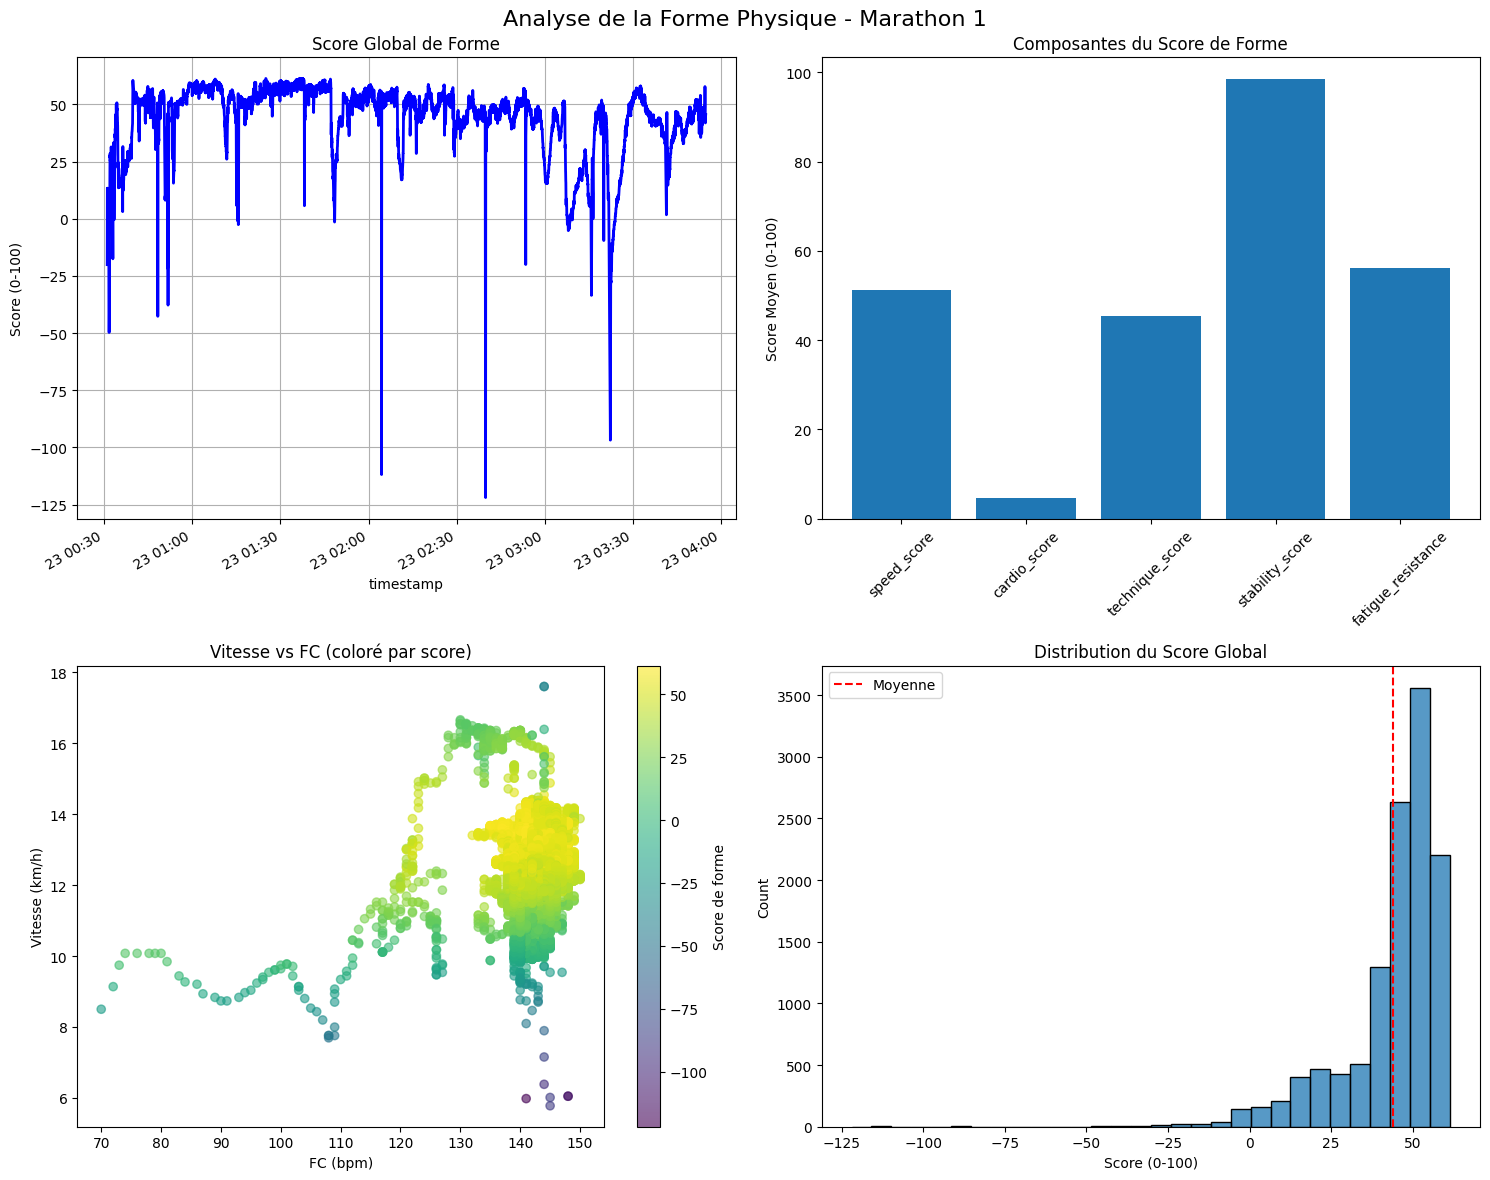


📊 Analyse du Score de Forme:

Scores moyens par composante:
speed_score: 51.1 ± 4.7
cardio_score: 4.7 ± 8.9
technique_score: 45.5 ± 59.1
stability_score: 98.5 ± 1.2
fatigue_resistance: 56.2 ± 22.3

Score global moyen: 43.9
Niveau général: Moyen


In [ ]:
def calculate_fitness_score(df, zones):
    """
    Calcule un score de forme physique global basé sur plusieurs métriques
    """
    fitness_metrics = pd.DataFrame(index=df.index)
    
    #Score de Vitesse (0-100)
    speed_range = zones[0]['Sprint'][1] - zones[0]['Récupération'][0]
    fitness_metrics['speed_score'] = ((df['enhanced_speed'] - zones[0]['Récupération'][0]) / 
                                    speed_range * 100).clip(0, 100)
    
    #Score d'Endurance Cardiaque (0-100)
    expected_hr = df['enhanced_speed'] * 6  # Approximation linéaire simple
    hr_efficiency = (expected_hr - df['heart_rate']) / expected_hr * 100
    fitness_metrics['cardio_score'] = (hr_efficiency + 100) / 2
    
    #Score Technique (0-100)
    technique_scores = []
    for param in ['step_length', 'stance_time', 'vertical_oscillation']:
        optimal_min, optimal_max = zones[2][param]['Optimal']
        range_min, range_max = zones[2][param]['Range']
        
        # Distance par rapport à la zone optimale
        values = df[param]
        scores = np.where(
            (values >= optimal_min) & (values <= optimal_max),
            100,  
            np.where(
                values < optimal_min,
                100 * (values - range_min) / (optimal_min - range_min),  # En dessous
                100 * (range_max - values) / (range_max - optimal_max)   # Au-dessus
            )
        )
        technique_scores.append(pd.Series(scores, index=df.index))
    
    fitness_metrics['technique_score'] = sum(technique_scores) / len(technique_scores)
    
    # Score de Stabilité (RVI)
    cv_df = calculate_running_variability_index(df)
    fitness_metrics['stability_score'] = 100 - cv_df['RVI'].clip(0, 100)
    
    #Score de Fatigue
    fatigue_indicators = detect_fatigue_phases(df)
    fitness_metrics['fatigue_resistance'] = 100 - (fatigue_indicators['fatigue_score'] * 100)
    
    #Score global avec poids
    weights = {
        'speed_score': 0.2,
        'cardio_score': 0.3,
        'technique_score': 0.2,
        'stability_score': 0.15,
        'fatigue_resistance': 0.15
    }
    
    fitness_metrics['global_fitness'] = sum(fitness_metrics[metric] * weight 
                                          for metric, weight in weights.items())
    
    return fitness_metrics

def plot_fitness_analysis(df, fitness_metrics, course_name):
    """
    Visualise l'analyse du score de forme physique
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Analyse de la Forme Physique - {course_name}', size=16)
    
    #Evolution du score global
    fitness_metrics['global_fitness'].plot(ax=ax1, color='blue', linewidth=2)
    ax1.set_title('Score Global de Forme')
    ax1.set_ylabel('Score (0-100)')
    ax1.grid(True)
    
    #Répartition des composantes du score
    components = ['speed_score', 'cardio_score', 'technique_score', 
                 'stability_score', 'fatigue_resistance']
    mean_scores = [fitness_metrics[comp].mean() for comp in components]
    ax2.bar(components, mean_scores)
    ax2.set_title('Composantes du Score de Forme')
    ax2.set_xticklabels(components, rotation=45)
    ax2.set_ylabel('Score Moyen (0-100)')
    
    #Relation vitesse/FC avec code couleur du score
    scatter = ax3.scatter(df['heart_rate'], df['enhanced_speed'],
                         c=fitness_metrics['global_fitness'],
                         cmap='viridis', alpha=0.6)
    ax3.set_title('Vitesse vs FC (coloré par score)')
    ax3.set_xlabel('FC (bpm)')
    ax3.set_ylabel('Vitesse (km/h)')
    plt.colorbar(scatter, ax=ax3, label='Score de forme')
    
    #Distribution du score global
    sns.histplot(fitness_metrics['global_fitness'], bins=30, ax=ax4)
    ax4.axvline(fitness_metrics['global_fitness'].mean(), color='r', 
                linestyle='--', label='Moyenne')
    ax4.set_title('Distribution du Score Global')
    ax4.set_xlabel('Score (0-100)')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    #Statistiques et interprétation
    print("\n Analyse du Score de Forme:")
    print("\nScores moyens par composante:")
    for component in components:
        mean_score = fitness_metrics[component].mean()
        std_score = fitness_metrics[component].std()
        print(f"{component}: {mean_score:.1f} ± {std_score:.1f}")
    
    print(f"\nScore global moyen: {fitness_metrics['global_fitness'].mean():.1f}")
    
    # Interprétation du niveau
    global_score = fitness_metrics['global_fitness'].mean()
    if global_score >= 80:
        level = "Excellent"
    elif global_score >= 60:
        level = "Bon"
    elif global_score >= 40:
        level = "Moyen"
    else:
        level = "À améliorer"
    
    print(f"Niveau général: {level}")
    
    return fitness_metrics

# Calcul et affichage du score de forme
fitness_metrics = calculate_fitness_score(time_series[course_name], zones)
fitness_analysis = plot_fitness_analysis(time_series[course_name], fitness_metrics, course_name)

## Analyse de récupération optimale

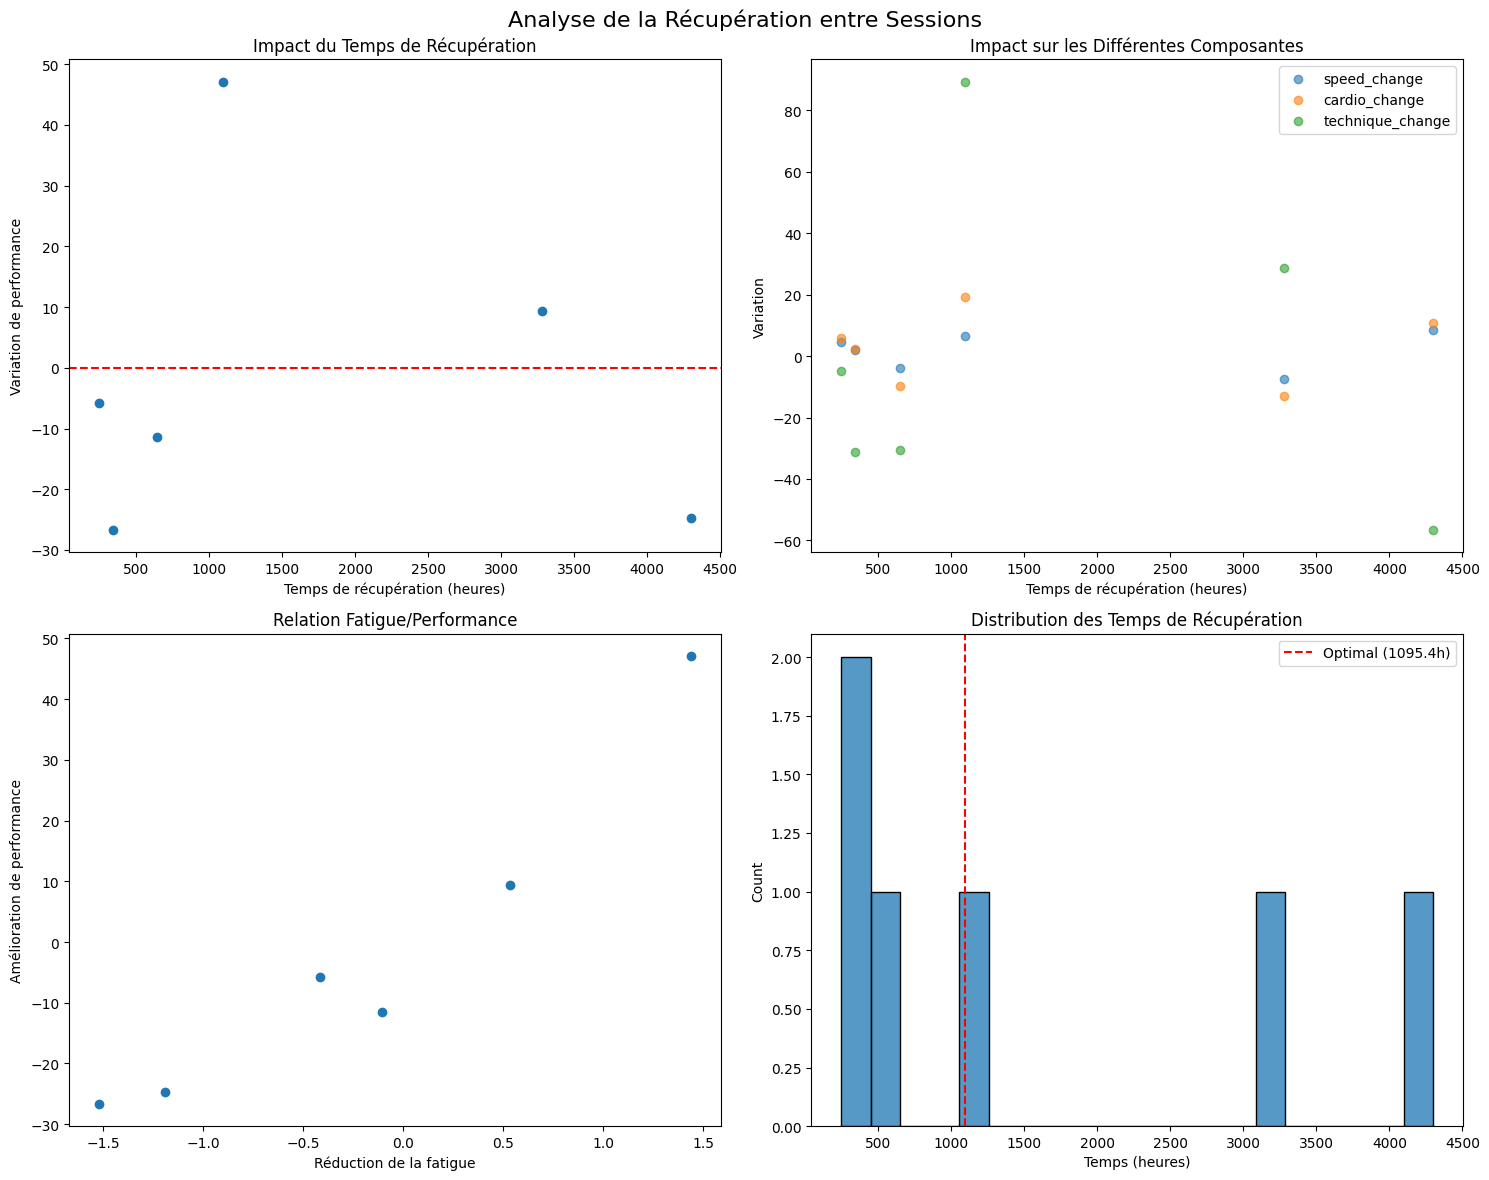


📊 Analyse de la Récupération:

Temps de récupération optimal: 1095.4 heures
Impact moyen sur la performance: -2.0 points
Corrélation temps/performance: -0.09

💡 Recommandations:
- Le temps de récupération actuel semble approprié


In [ ]:
def analyze_recovery(time_series):
    """
    Analyse l'impact de la récupération entre les sessions
    """
    # Création d'un DataFrame avec les métriques par course
    recovery_analysis = []
    
    sorted_courses = sorted(time_series.items(), key=lambda x: x[1].index[0])
    
    for i in range(1, len(sorted_courses)):
        prev_course = sorted_courses[i-1]
        curr_course = sorted_courses[i]
        
        # Calcul du temps de récupération
        recovery_time = (curr_course[1].index[0] - prev_course[1].index[-1]).total_seconds() / 3600  # en heures
        
        # Calcul des métriques de performance
        prev_metrics = calculate_fitness_score(prev_course[1], zones)
        curr_metrics = calculate_fitness_score(curr_course[1], zones)
        
        # Comparaison des performances
        performance_delta = {
            'global_fitness': curr_metrics['global_fitness'].mean() - prev_metrics['global_fitness'].mean(),
            'speed_score': curr_metrics['speed_score'].mean() - prev_metrics['speed_score'].mean(),
            'cardio_score': curr_metrics['cardio_score'].mean() - prev_metrics['cardio_score'].mean(),
            'technique_score': curr_metrics['technique_score'].mean() - prev_metrics['technique_score'].mean()
        }
        
        # Analyse de la fatigue
        prev_fatigue = detect_fatigue_phases(prev_course[1])['fatigue_score'].mean()
        curr_fatigue = detect_fatigue_phases(curr_course[1])['fatigue_score'].mean()
        
        recovery_analysis.append({
            'previous_course': prev_course[0],
            'current_course': curr_course[0],
            'recovery_time': recovery_time,
            'performance_change': performance_delta['global_fitness'],
            'speed_change': performance_delta['speed_score'],
            'cardio_change': performance_delta['cardio_score'],
            'technique_change': performance_delta['technique_score'],
            'fatigue_difference': prev_fatigue - curr_fatigue
        })
    
    recovery_df = pd.DataFrame(recovery_analysis)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Analyse de la Récupération entre Sessions', size=16)
    
    #Impact du temps de récupération sur la performance
    ax1.scatter(recovery_df['recovery_time'], recovery_df['performance_change'])
    ax1.set_title('Impact du Temps de Récupération')
    ax1.set_xlabel('Temps de récupération (heures)')
    ax1.set_ylabel('Variation de performance')
    ax1.axhline(y=0, color='r', linestyle='--')
    
    #Comparaison des composantes
    components = ['speed_change', 'cardio_change', 'technique_change']
    for component in components:
        ax2.scatter(recovery_df['recovery_time'], recovery_df[component], 
                   label=component, alpha=0.6)
    ax2.set_title('Impact sur les Différentes Composantes')
    ax2.set_xlabel('Temps de récupération (heures)')
    ax2.set_ylabel('Variation')
    ax2.legend()
    
    #Relation fatigue/performance
    ax3.scatter(recovery_df['fatigue_difference'], recovery_df['performance_change'])
    ax3.set_title('Relation Fatigue/Performance')
    ax3.set_xlabel('Réduction de la fatigue')
    ax3.set_ylabel('Amélioration de performance')
    
    #Temps de récupération optimal
    optimal_recovery = recovery_df.loc[recovery_df['performance_change'].idxmax()]['recovery_time']
    sns.histplot(recovery_df['recovery_time'], bins=20, ax=ax4)
    ax4.axvline(optimal_recovery, color='r', linestyle='--', 
                label=f'Optimal ({optimal_recovery:.1f}h)')
    ax4.set_title('Distribution des Temps de Récupération')
    ax4.set_xlabel('Temps (heures)')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\n Analyse de la Récupération:")
    print(f"\nTemps de récupération optimal: {optimal_recovery:.1f} heures")
    mean_impact = recovery_df['performance_change'].mean()
    print(f"Impact moyen sur la performance: {mean_impact:+.1f} points")
    corr_time_perf = recovery_df['recovery_time'].corr(recovery_df['performance_change'])
    print(f"Corrélation temps/performance: {corr_time_perf:.2f}")
    print("\n Recommandations:")
    if corr_time_perf > 0.3:
        print("- Augmenter le temps de récupération pourrait améliorer les performances")
    elif corr_time_perf < -0.3:
        print("- Réduire le temps de récupération pourrait maintenir un meilleur niveau")
    else:
        print("- Le temps de récupération actuel semble approprié")
    
    return recovery_df

# Analyse de la récupération
recovery_analysis = analyze_recovery(time_series)